# Introduction

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

The idea here was to create a centralized pattern method to predict the next six weeks, using data science tools, like machine learning to read the variables and get their behavior comparing their correlation, and historic, then creating a sales prediction up to six weeks ahead, with the best and worst scenario furthermore the percentage that how accurate is the prediction, because it depends on each store.

Having the final result, the CEO could choose which store to invest more based on how much and precise the results about the store would be.

## Imports

In [1]:
# List of all libraries used in the project

import math
import numpy  as np
import pandas as pd
import random
import pickle
import requests
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
import datetime

from tabulate              import tabulate
from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML

from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

## Understanding the Libraries

1. **math:** This library provides mathematical functions and constants in Python. It can be useful for performing mathematical operations in a program.


2. **numpy:** This library provides functions for working with arrays and matrices in Python. It can be useful for numerical computations and data analysis.


3. **pandas:** This library provides data structures and functions for working with tabular data in Python. It can be useful for data cleaning, manipulation, and analysis.


4. **random:** This library provides functions for generating random numbers and sequences. It can be useful for generating random inputs to test functions or simulating random events in a program.


5. **pickle:** This library provides functions for serializing and deserializing Python objects. It can be used to save objects to a file or send them over a network connection.


6. **requests:** This library provides functions for making HTTP requests from Python. It can be used to interact with web APIs or download files from the internet.


7. **warnings:** This library provides a way to issue warnings from Python code. It can be used to alert users of potential issues or deprecated functionality in a library.


8. **inflection:** This library provides functions for transforming strings to different cases. It can be useful for formatting column names in pandas dataframes or other data cleaning tasks.


9. **seaborn:** This library is used for creating visualizations in Python. It provides a high-level interface for creating statistical graphics, such as heatmaps, scatter plots, and bar charts.


10. **xgboost:** This library is used for building gradient boosted trees, which are a popular machine learning algorithm for regression and classification tasks.


11. **datetime:** This library provides classes for working with dates and times in Python.


12. **tabulate:** This library is used for creating tables in Python. It can create tables from various data sources, including lists, dictionaries, and pandas dataframes.


13. **scipy:** This library contains a wide range of scientific computing functions, including algorithms for optimization, signal processing, linear algebra, and more.


14. **boruta:** This library is used for feature selection in machine learning. It employs a random forest algorithm to evaluate the importance of each feature and determine whether it should be included in the final model.


15. **matplotlib:** This library is used for creating visualizations in Python. It provides a wide range of plotting functions for creating line plots, scatter plots, bar charts, and more.


16. **IPython.display:** This module provides a way to display rich media in the Jupyter Notebook environment.


17. **IPython.core.display:** This module contains the same functions as IPython.display, but is intended for use in IPython extensions and other low-level code.


18. **sklearn.metrics:** This library contains various metrics and evaluation techniques for machine learning models.


19. **sklearn.ensemble:** This library contains ensemble learning algorithms such as random forests, bagging, and boosting.


20. **sklearn.linear_model:** This library contains various linear regression and classification models.


21. **sklearn.preprocessing:** This library contains various data preprocessing techniques such as scaling, normalization, and imputation.


## Help Functions

In [2]:
# This function was created to validate the model, checking the different kind of errors ( MAE, MAPE and RMSE)

'''
x_training: a pandas dataframe containing the training dataset
kfold: an integer value representing the number of folds to be used in k-fold cross-validation
model_name: a string representing the name of the machine learning model being used
model: a machine learning model object that can be fitted to the data
verbose: a boolean indicating whether or not to display progress updates during the cross-validation process (default is False)
'''

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    '''
    The function first creates empty lists to store the performance metrics of each fold iteration. It then iterates over the range of 
    k-fold values in reverse order, starting from the highest value and ending at 1. For each iteration, it filters the training and 
    validation datasets based on the start and end dates of the validation set.
    '''

    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
            
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days= k * 6 * 7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=( k - 1 ) * 6 *7 )
        
        '''
        Next, it separates the features and target variables for both the training and validation sets. It then fits the model 
        on the training set and predicts the target variable for the validation set. The performance of the model is then evaluated using 
        the ml_error function.
        '''

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[( x_training['date'] >= validation_start_date ) & ( x_training['date'] <= validation_end_date )]

        # training and validation dataset
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
        
        '''
        The mean and standard deviation of the performance metrics for all k-fold iterations are then computed and returned as a pandas 
        dataframe. The performance metrics include the mean absolute error (MAE), mean absolute percentage error (MAPE), and 
        root mean squared error (RMSE)
        '''
        
    return pd.DataFrame( {'Model Name': model_name, 
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + 
                          ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ), 
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + 
                          ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ), 
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + 
                          ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

# Today we have all the 3 functions insides the module sklearn.metrics to Calcute the errors below

'''
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
'''

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

'''
The function cramer_v() calculates the Cramer's V correlation coefficient between two categorical variables x and y.
Cramer's V is a measure of association between two nominal variables that takes values between 0 and 1,
where 0 indicates no association and 1 indicates complete association.
'''

def cramer_v( x, y ):
    
    '''
    The function first creates a contingency table cm using pd.crosstab() function which shows the frequency of 
    occurrence of each combination of categories for the two variables.
    '''
    
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k =cm.shape
    
    '''
    Then it calculates the chi-square statistic using ss.chi2_contingency() function and corrects it using degrees of freedom to account
    for small sample sizes.
    '''
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    
    '''
    Finally, it calculates the Cramer's V coefficient by dividing the corrected chi-square statistic by the square root of the product of 
    the corrected number of rows and columns minus 1. The result is returned as a single value between 0 and 1.
    '''
    
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr - 1)))

# This Function create a better visual set to Jupyter

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

jupyter_settings()


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Load the Data

In [3]:
# Read the archive and save in the memory

df_sales_raw = pd.read_csv(r'C:train.csv', low_memory=False)
df_store_raw = pd.read_csv(r'C:store.csv', low_memory=False)

# Low memory idicates if you have enough memory to read all the data by once


## Checking how the both datasets are to do a Merge based on their columns

In [4]:
df_sales_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
df_store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
# Merging

df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')


In [7]:
# Checking the result

df_raw.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# Describing the Data (Step One)

In [8]:
# Always create a checkpoint to not lose the entire progress, and avoid restarting all the script

df1 = df_raw.copy()


## Rename Columns

In [9]:
# Get the name of all columns

df1.columns


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [10]:
# Rename columns makes it easier to us to access the data later.

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

# The fucntion infletion will create the snakecase pattern in the columns' name

snakecase = lambda x: inflection.underscore( x )

# Now we use map to apply the function in all columns and then add it to a list

cols_new = list( map( snakecase, cols_old ) )

# Rename columns

df1.columns = cols_new


In [11]:
# Checking the new columns

df1.columns


Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## Data Dimensions

In [12]:
# Find out how big the dataset is

print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')


Number of Rows: 1017209
Number of Columns: 18


## Data Types

In [13]:
# Checking the type of each column to identify possible changes

df1.dtypes


store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [14]:
# Change the columns with date, to a datetime type instead of object

df1['date'] = pd.to_datetime( df1['date'] )

# Checking if the change really happended 

df1.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Checking NA

In [15]:
# Sum how many NAs we have in each column

df1.isna().sum()


store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### What can we do with the NAs?

Each situation will bring a certain needy, but most of all the times, we can simply:

1. discard the lines, if there aren't a lot of them, or if the columns isn't important.
2. Use a ML to fulfill the empty values based on a learning behavior inside the dataset
3. Use the mean or median as a pattern value
4. Or use a simple number that doesn't interfere in the analyze


## Fill out NA

In [16]:
# Take a Sample of the dataset

df1.sample(20)


,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
601113,914,4,2014-01-09,9949,1227,1,1,0,0,c,c,2640.0,4.0,2011.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
29977,988,7,2015-07-05,0,0,0,0,0,0,a,a,30.0,11.0,2012.0,0,NaN,NaN,NaN
577119,335,4,2014-01-30,13556,2694,1,0,0,0,b,a,90.0,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
229789,100,2,2015-01-06,0,0,0,1,a,0,d,a,17930.0,NaN,NaN,0,NaN,NaN,NaN
689118,834,2,2013-10-22,6552,678,1,1,0,0,a,a,3470.0,3.0,2012.0,0,NaN,NaN,NaN
306058,583,6,2014-10-18,2591,287,1,0,0,0,a,a,2640.0,11.0,2002.0,0,NaN,NaN,NaN
540412,423,2,2014-03-04,11182,1738,1,1,0,0,b,a,1270.0,5.0,2014.0,0,NaN,NaN,NaN
890672,573,3,2013-04-24,3872,350,1,1,0,0,a,a,1190.0,11.0,2012.0,1,36.0,2013.0,"Jan,Apr,Jul,Oct"
715102,58,6,2013-09-28,6022,528,1,0,0,0,a,c,7340.0,5.0,2008.0,1,27.0,2012.0,"Jan,Apr,Jul,Oct"
669732,403,5,2013-11-08,8711,899,1,1,0,0,a,a,4970.0,7.0,2015.0,0,NaN,NaN,NaN


In [17]:
# Competition distance, let's consider a huge distance that couldn't create a competition at all

df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000 if math.isnan( x ) else x )

# Competion open_since_month and since_year, assume the sale date if competition is NAN

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] )
                                                else x['competition_open_since_month'], axis=1 )
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] )
                                               else x['competition_open_since_year'], axis=1 )

# Promo2_since_week and promo2_since_year use the same concept as above

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1 )
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1 )

# Promo_interval, create a Dictionary to relate months with their respectively numbers

month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

# Fulfill the NAs with 0, no promo

df1['promo_interval'].fillna( 0, inplace=True )

# Use the map to create the month_map column based on which month the sale happended

df1['month_map'] = df1['date'].dt.month.map( month_map )

# Identify if the sale was done within the promo interval

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 
                                                             else 1 if x['month_map'] in x['promo_interval'].split( ',' ) 
                                                             else 0, axis=1 )


In [18]:
# Looking into if we could treat the NAs

df1.isna().sum()


store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## Change the Data types

In [19]:
# After modificating the dataset, maybe the columns type has chosen

df1.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [20]:
# Now let's reorganize the types as they must be

# Competition_open

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

# Promo 2

df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )


## Descriptive Statistics

In [21]:
# We are going to divide the columns into two datasets with different kind of variables ( Numeral and categorical )

num_attributes = df1.select_dtypes( include=['float64', 'int64'] )
cat_attributes = df1.select_dtypes( exclude=['float64', 'int64', 'datetime64[ns]'] )


The idea is to create a dataset to analyze the data we have, and seek for insights

### Numerical Attributes

In [22]:
# Central tendency - mean and median

ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,promo2_since_week,1.0,52.0,51.0,23.619033,22.0,14.310057,0.178723,-1.184046


**Seaborn Distplot represents the overall distribution of continuous data variables, is a convenient way to visualize the distribution of a variable in a Pandas DataFrame using Seaborn library.**

Overall, a Distplot chart provides a useful visual representation of the distribution of a dataset, allowing you to quickly identify the range of the data, the most common values, and any outliers or unusual patterns.

<AxesSubplot: xlabel='sales', ylabel='Density'>

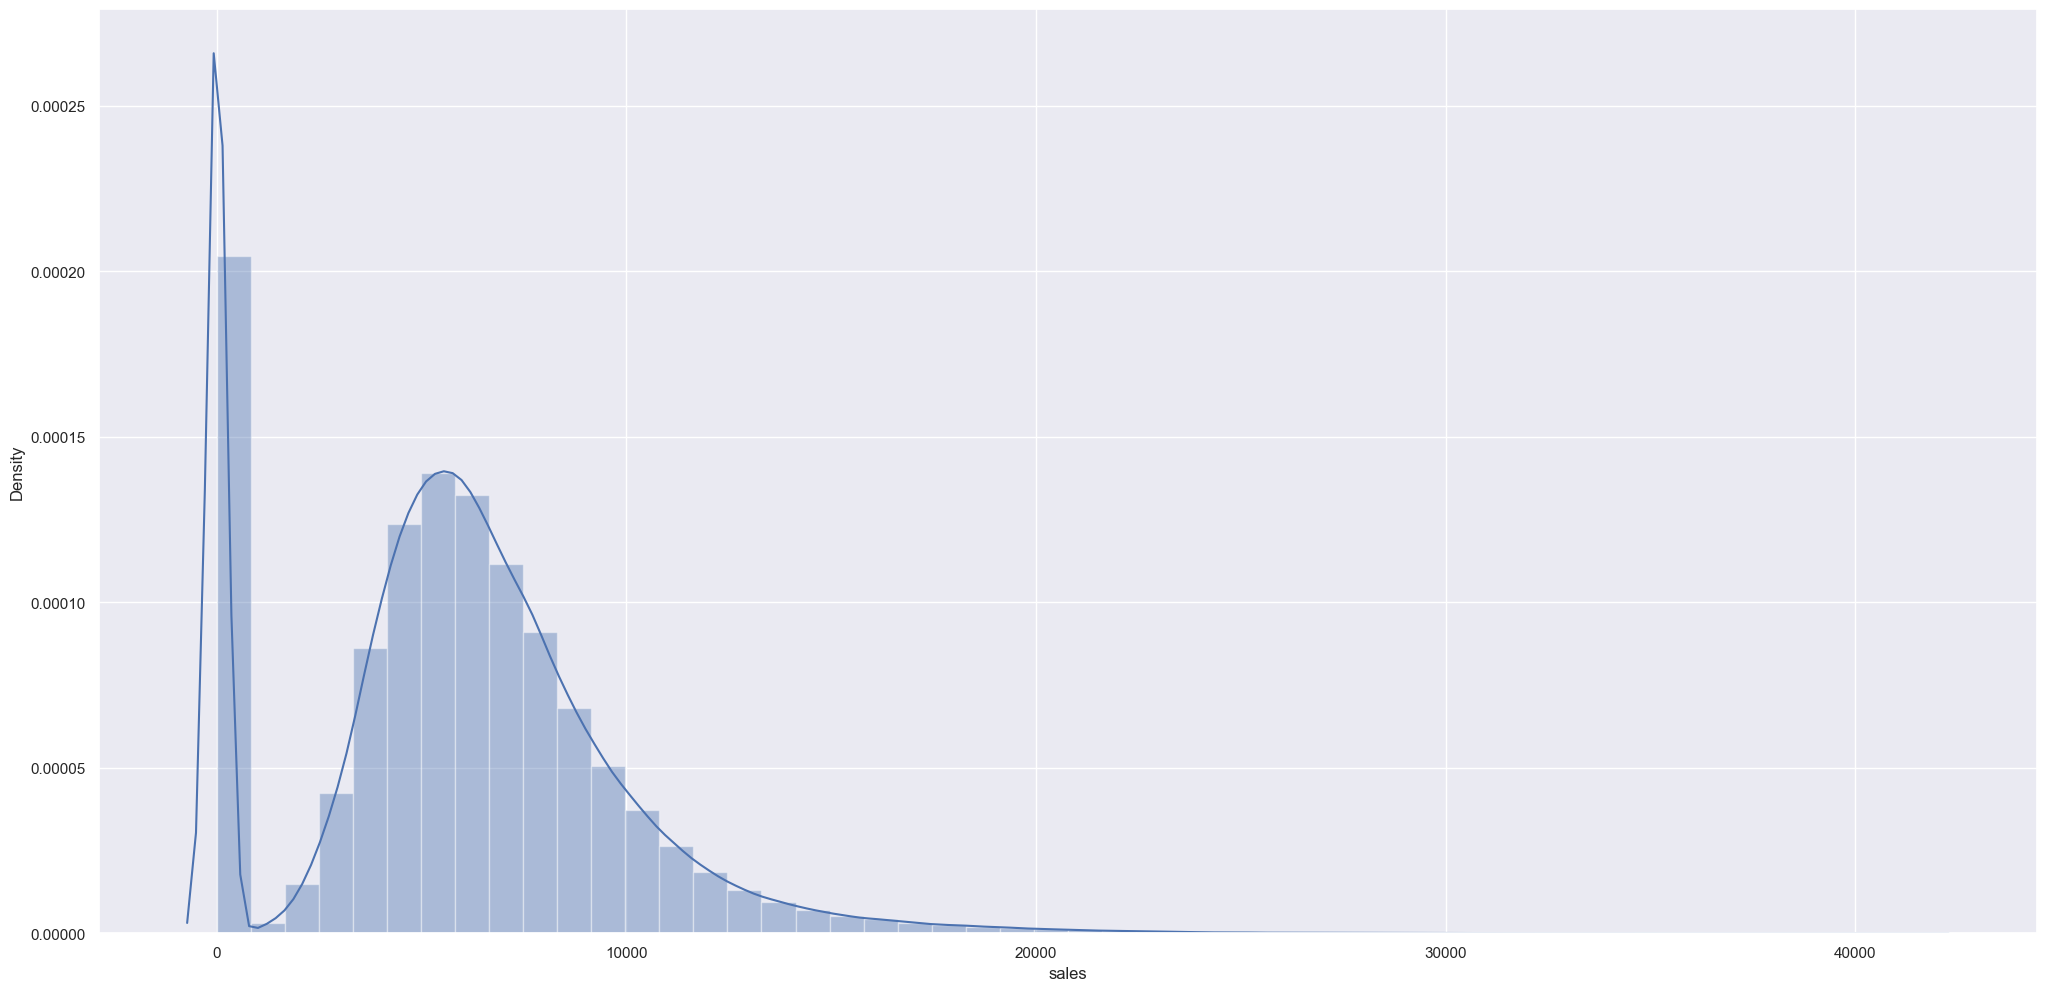

In [23]:
sns.distplot( df1['sales'] )

### Categorical Attributes

In [24]:
# Check the range of the variables

cat_attributes.apply( lambda x: x.unique().shape[0] )


state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo_interval                   4
month_map                       12
dtype: int64

<AxesSubplot: xlabel='assortment', ylabel='sales'>

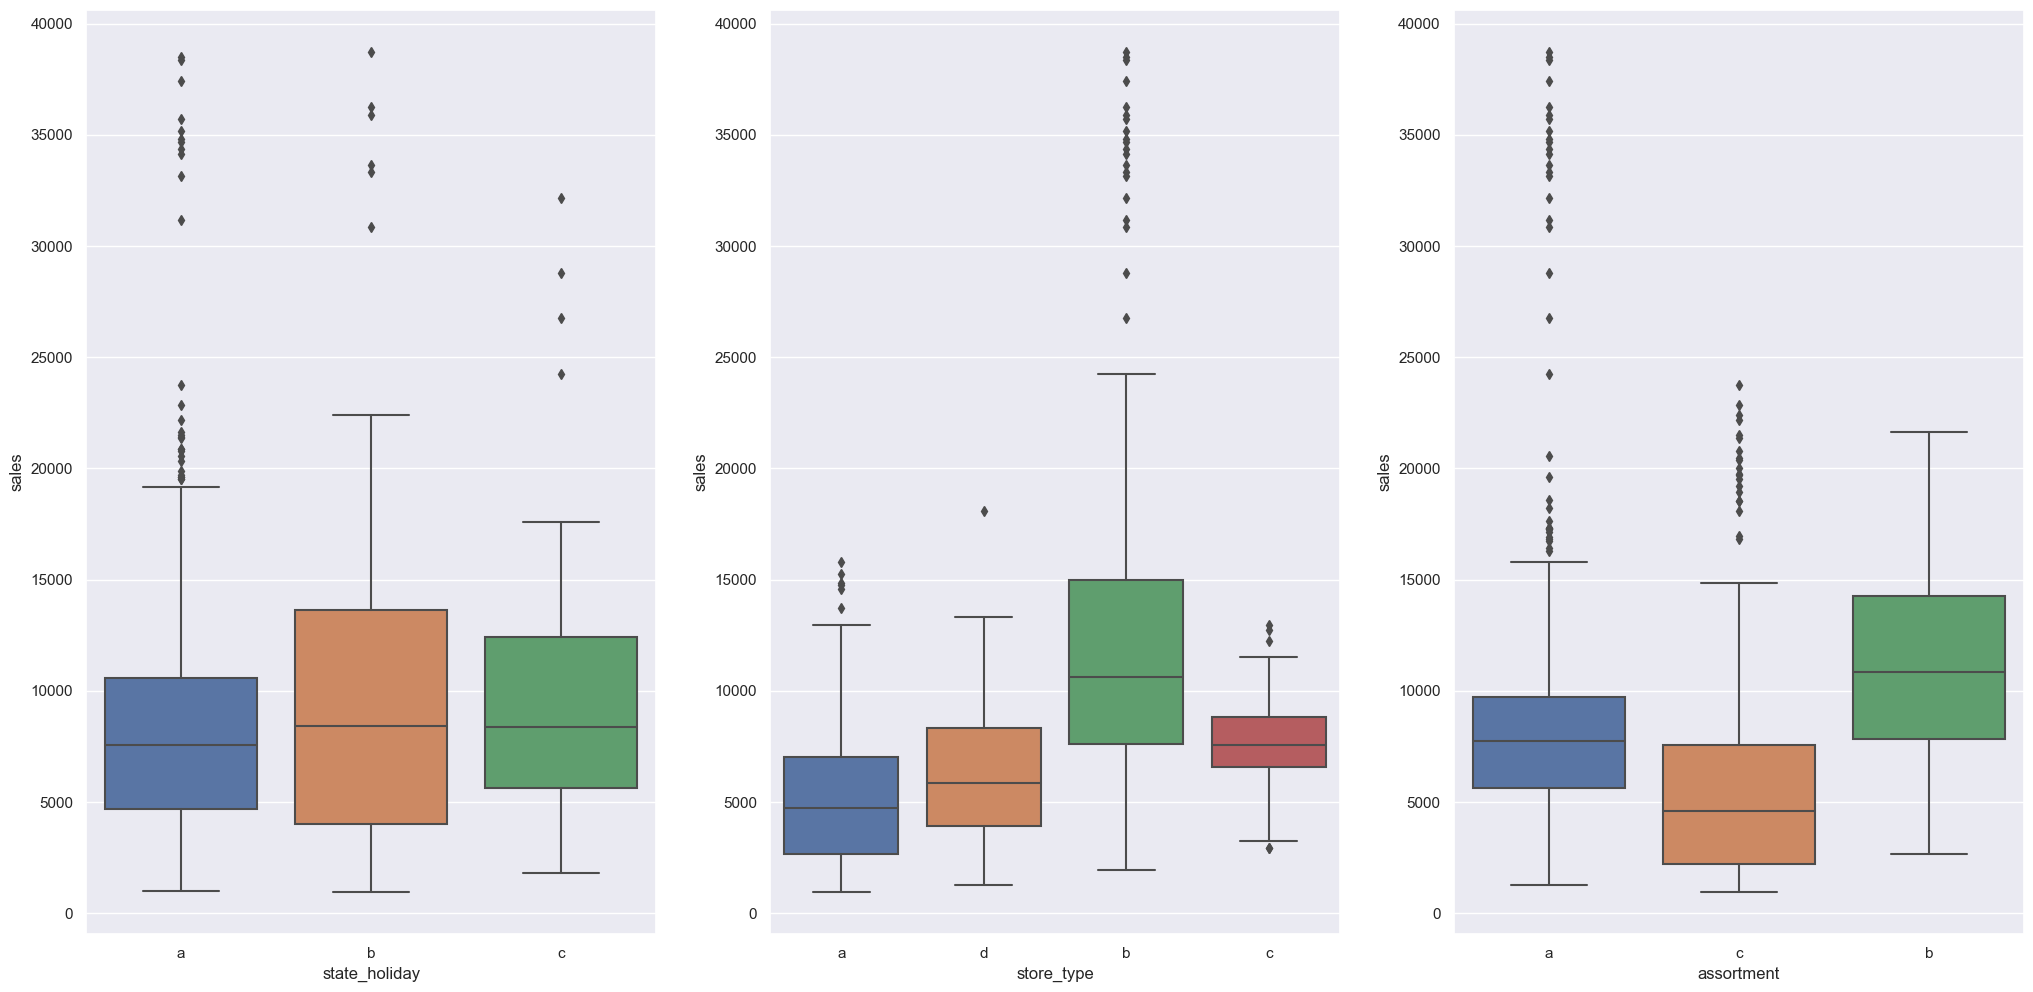

In [25]:
# Use seaborn to analyze how the categorical variables act

aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux )


# Feature Engineering (Second Step)

In [26]:
# Show the brainstorm done regarding some hypothesis 

Image( r'C:Brainstorm.jpg')


FileNotFoundError: No such file or directory: 'C:Brainstorm.jpg'

FileNotFoundError: No such file or directory: 'C:Brainstorm.jpg'

<IPython.core.display.Image object>

## Creating Hypothesis

### Store Hypothesis

**1.** Stores with the most number of employee should sell more;

**2.** Stores with the most capacity of warehouse should sell more;

**3.** Big Stores should sell more;

**4.** Stores with the most assortment should sell more;

**5.** Stores with the closest competitors should sell less;

**6.** Stores with the oldest competitors should sell less.

### Product Hypothesis

**1.** Stores which invest the most in marketing should sell more;

**2.** Stores with the most showcase of products should sell more;

**3.** Stores with the cheapest products should sell more;

**5.** Stores with the most agressive discounts should sell more;

**6.** Stores with active discount for a longer time should sell more;

**7.** Stores with the most days on sale should sell more;

**8.** Stores with frequent discounts should sell more.

### Time Hypothesis

**1.** Stores which open at holidays should sell more;

**2.** Stores should sell more throughout the years;

**3.** Stores should sell more in the second semester;

**4.** Stores should sell more after the 10th of the each month;

**5.** Stores should sell less in the weekends;

**6.** Stores should sell less during scholars holidays

## Final Hypothesis List

**1.** Stores with the most assortment should sell more;

**2.** Stores with the closest competitors should sell less;

**3.** Stores with the oldest competitors should sell more;

**4.** Stores with active discount for a longer time should sell more;

**5.** Stores with the most days on sale should sell more;

**6.** Stores with frequent discounts should sell more;

**7.** Stores should sell more during Christmas;

**8.** Stores should sell more throughout the years;

**9.** Stores should sell more in the second semester;

**10.** Stores should sell more after the 10th of the each month;

**11.** Stores should sell less in the weekends;

**12.** Stores should sell less during scholars holidays.


## Adding Features
The Idea is to create new columns (features) before starting the data analyze.

In [27]:
# Checkpoint 2

df2 = df1.copy()

# Year, month, year, Year of week, Year week ( Creating Columns related to specific time)

df2['year'] = df2['date'].dt.year
df2['month'] = df2['date'].dt.month
df2['day'] = df2['date'].dt.day
df2['week_of_year'] = df2['date'].dt.weekofyear
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# Competition since

df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], 
                                                                  month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# Promo Since

df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( int )

# Assortment

df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# State Holiday

df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas'
                                                 if x == 'c' else 'regular_day' )


In [28]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# Variable Filtering (Third Step)

In [29]:
# Checkpoint 3

df3 = df2.copy()


## Line Filtering

In [30]:
# Take out all the lines the stores were closed

df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]


## Column Selection

In [31]:
# Take out the columns we won't use or we can't use their information

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )


# Data Analysis (Fourth Step)

In [32]:
# Checkpoint 4

df4 = df3.copy()


## Univariable Analyse

### Response Variable

<AxesSubplot: xlabel='sales'>

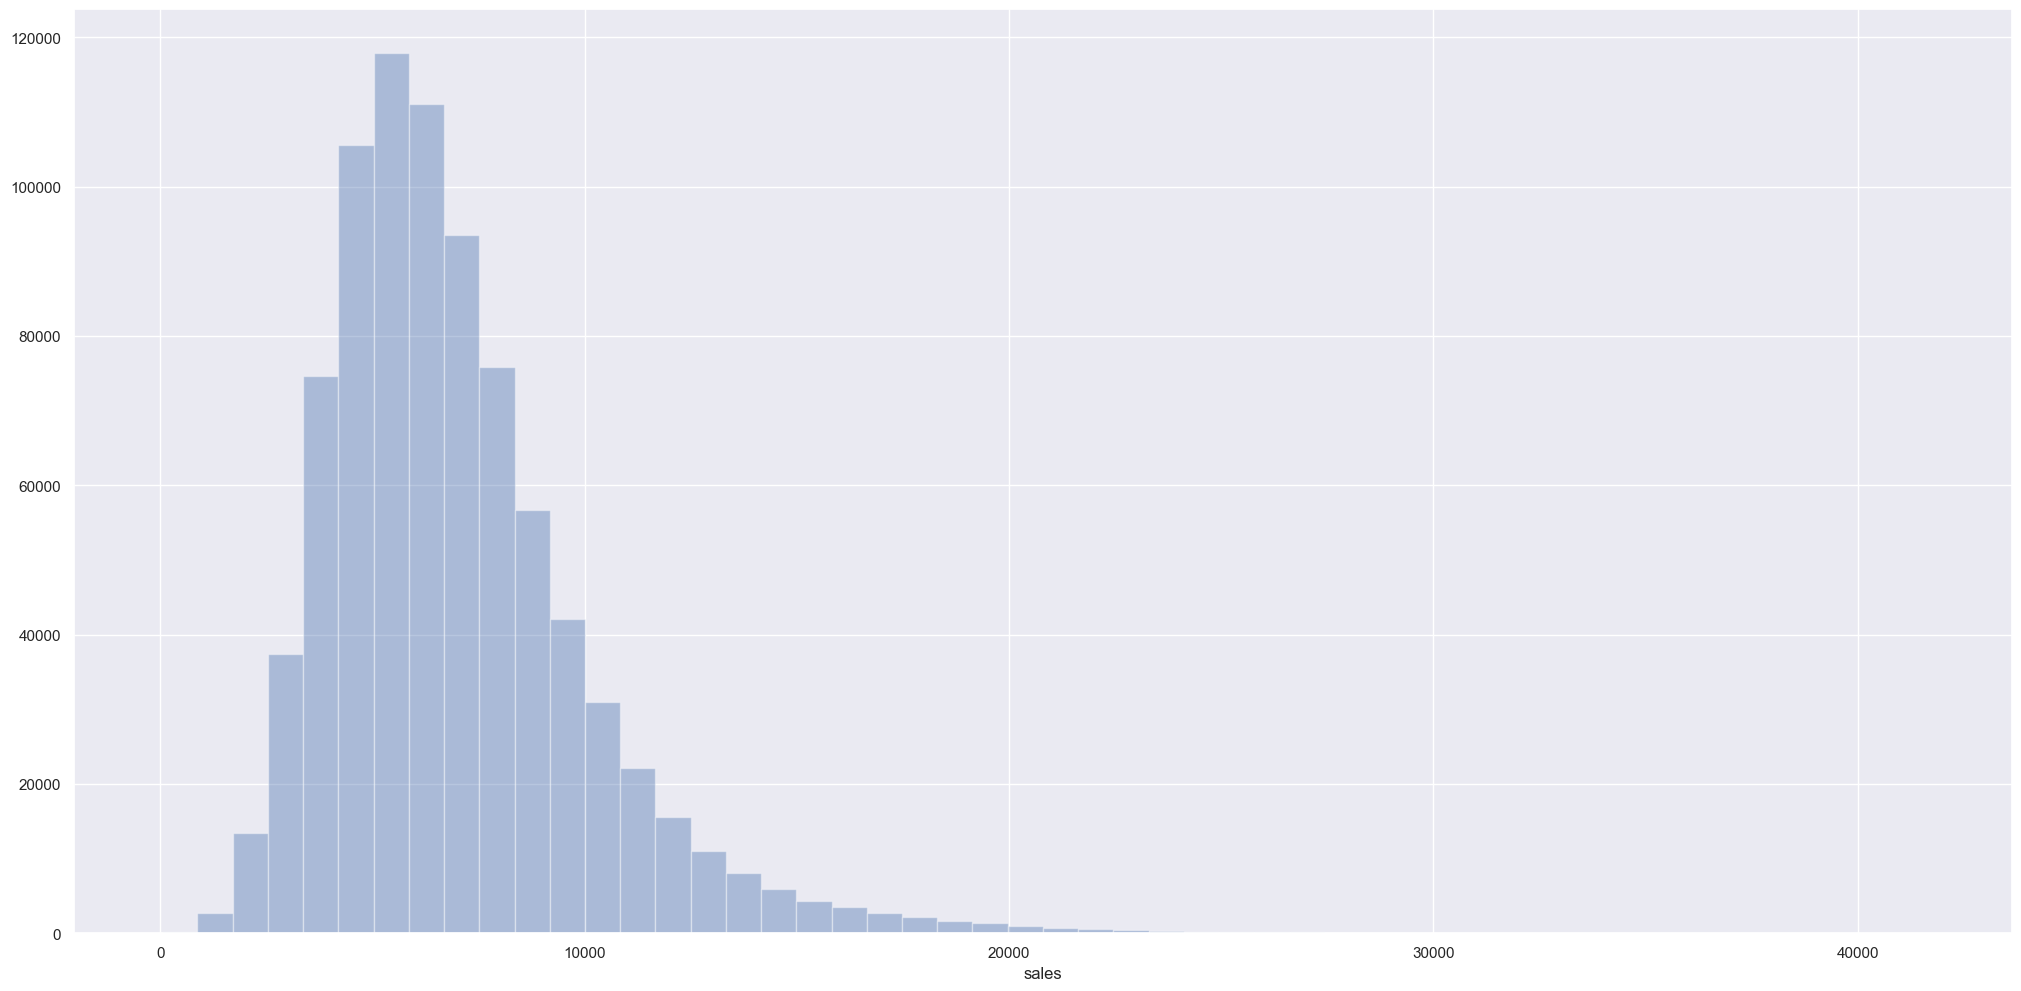

In [33]:
# Check the behavior of our response variable

sns.distplot( df4['sales'], kde=False )


<AxesSubplot: xlabel='sales', ylabel='Density'>

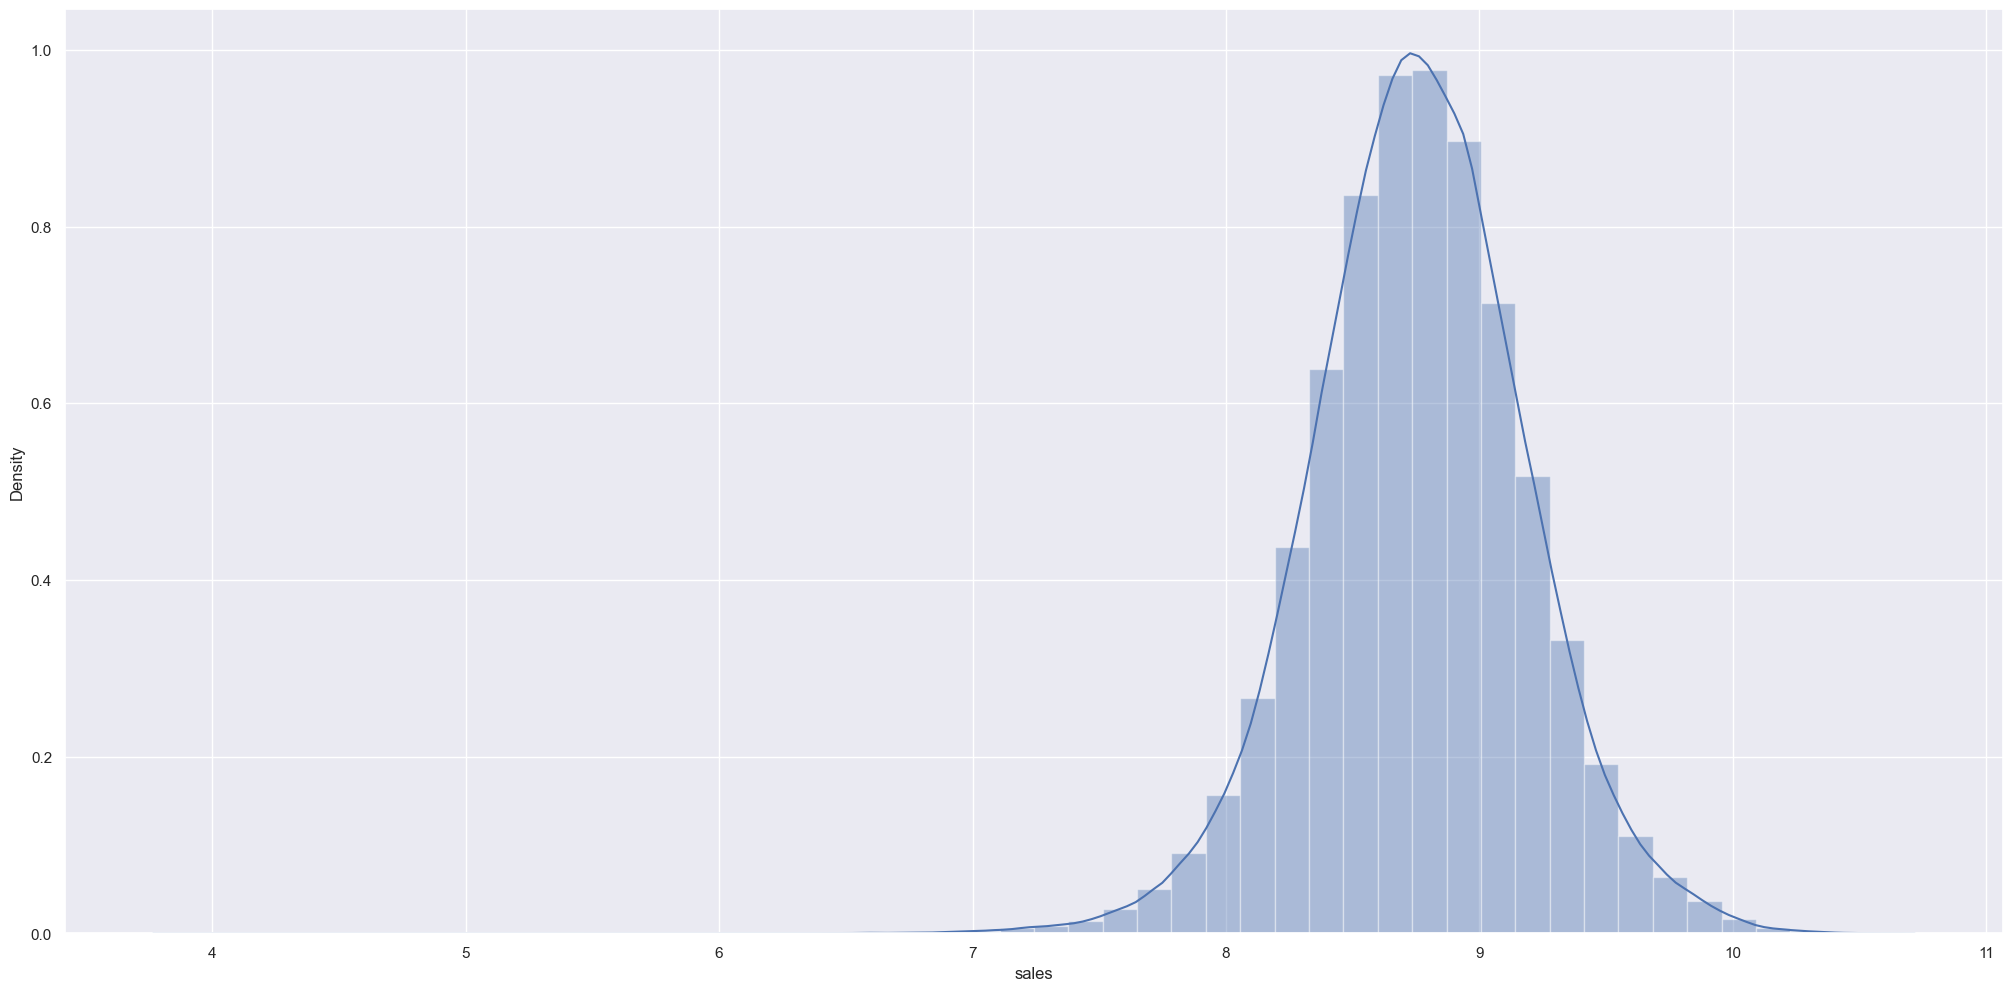

In [34]:
# One of the requirements is to make the variable more normal as possible, thus we can see better the behavior

sns.distplot( np.log1p( df4['sales'] ) )


### Numerical Variables

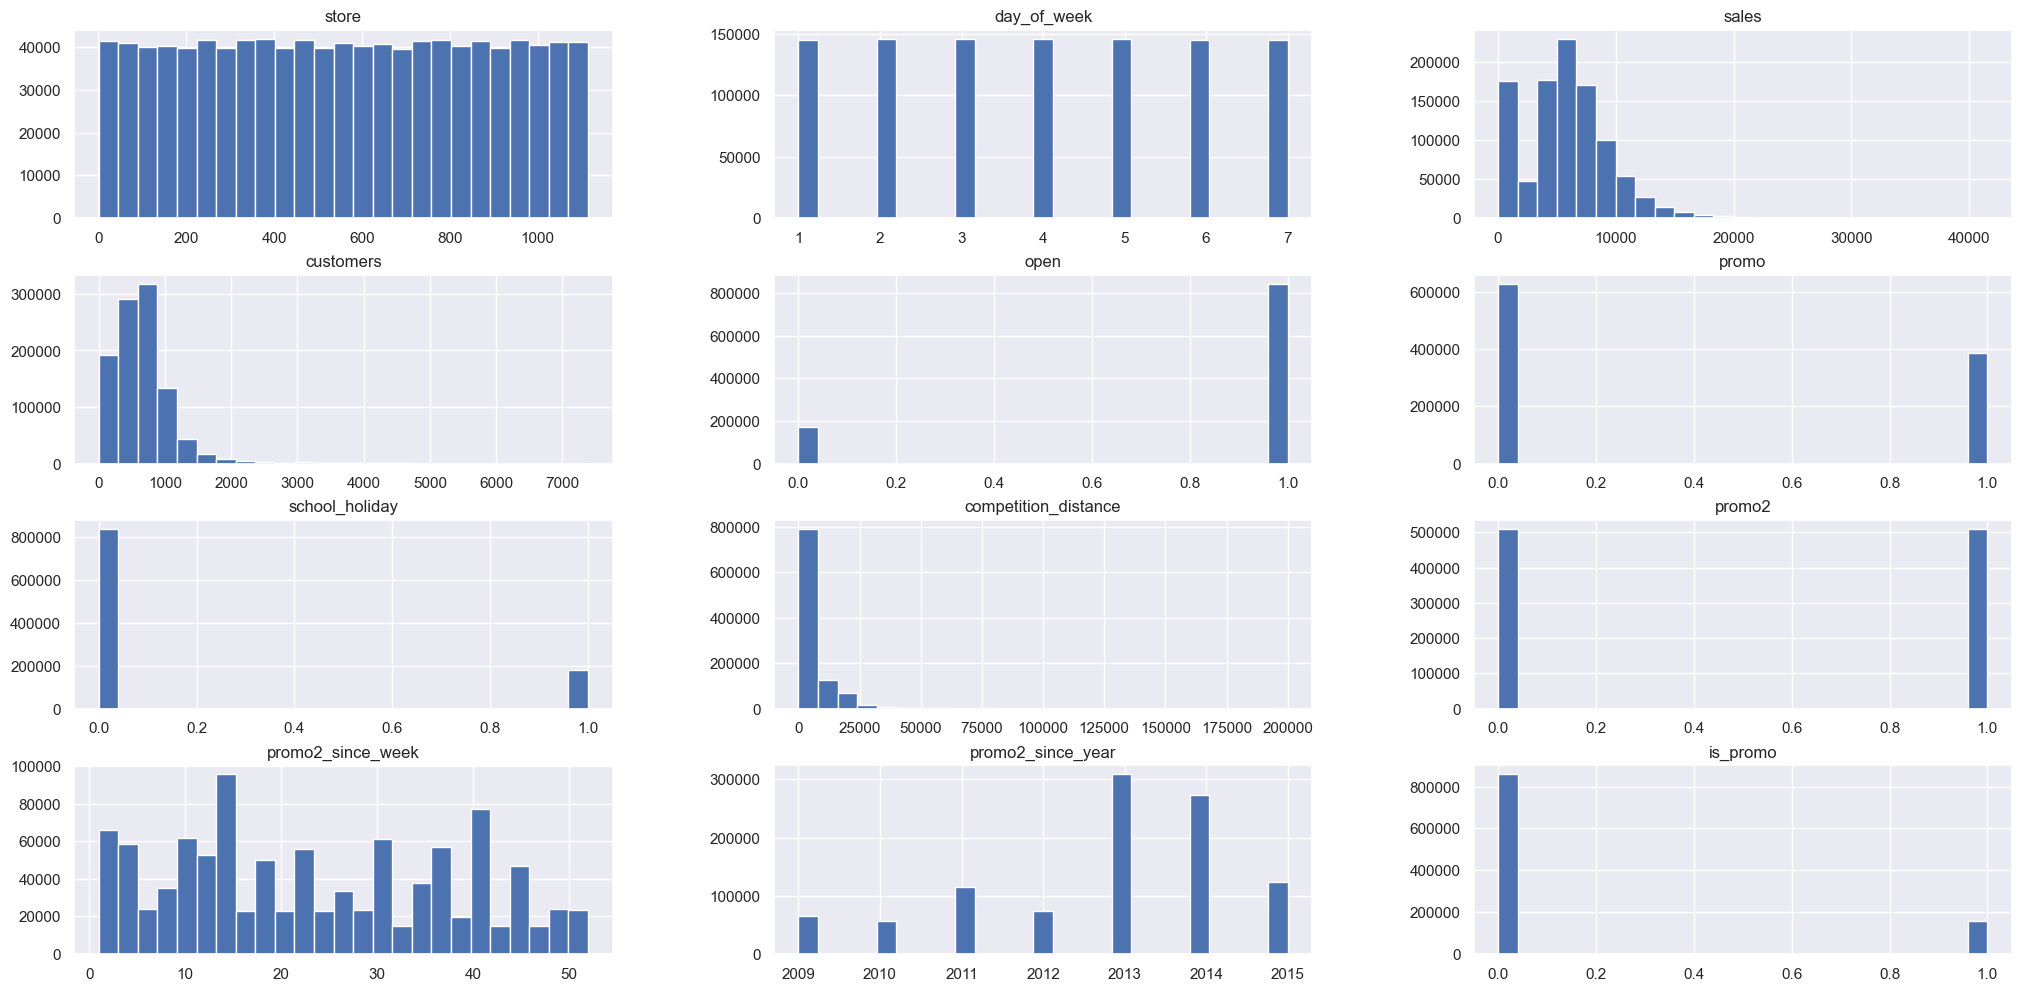

In [35]:
# Analyse each variable to see their behaviors individualy

num_attributes.hist( bins=25 );

# This can be useful for visualizing the distribution of the data and identifying any patterns or outliers.


### Categorical Variable

In [36]:
df4['state_holiday'].drop_duplicates()
df4['store_type'].drop_duplicates()
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

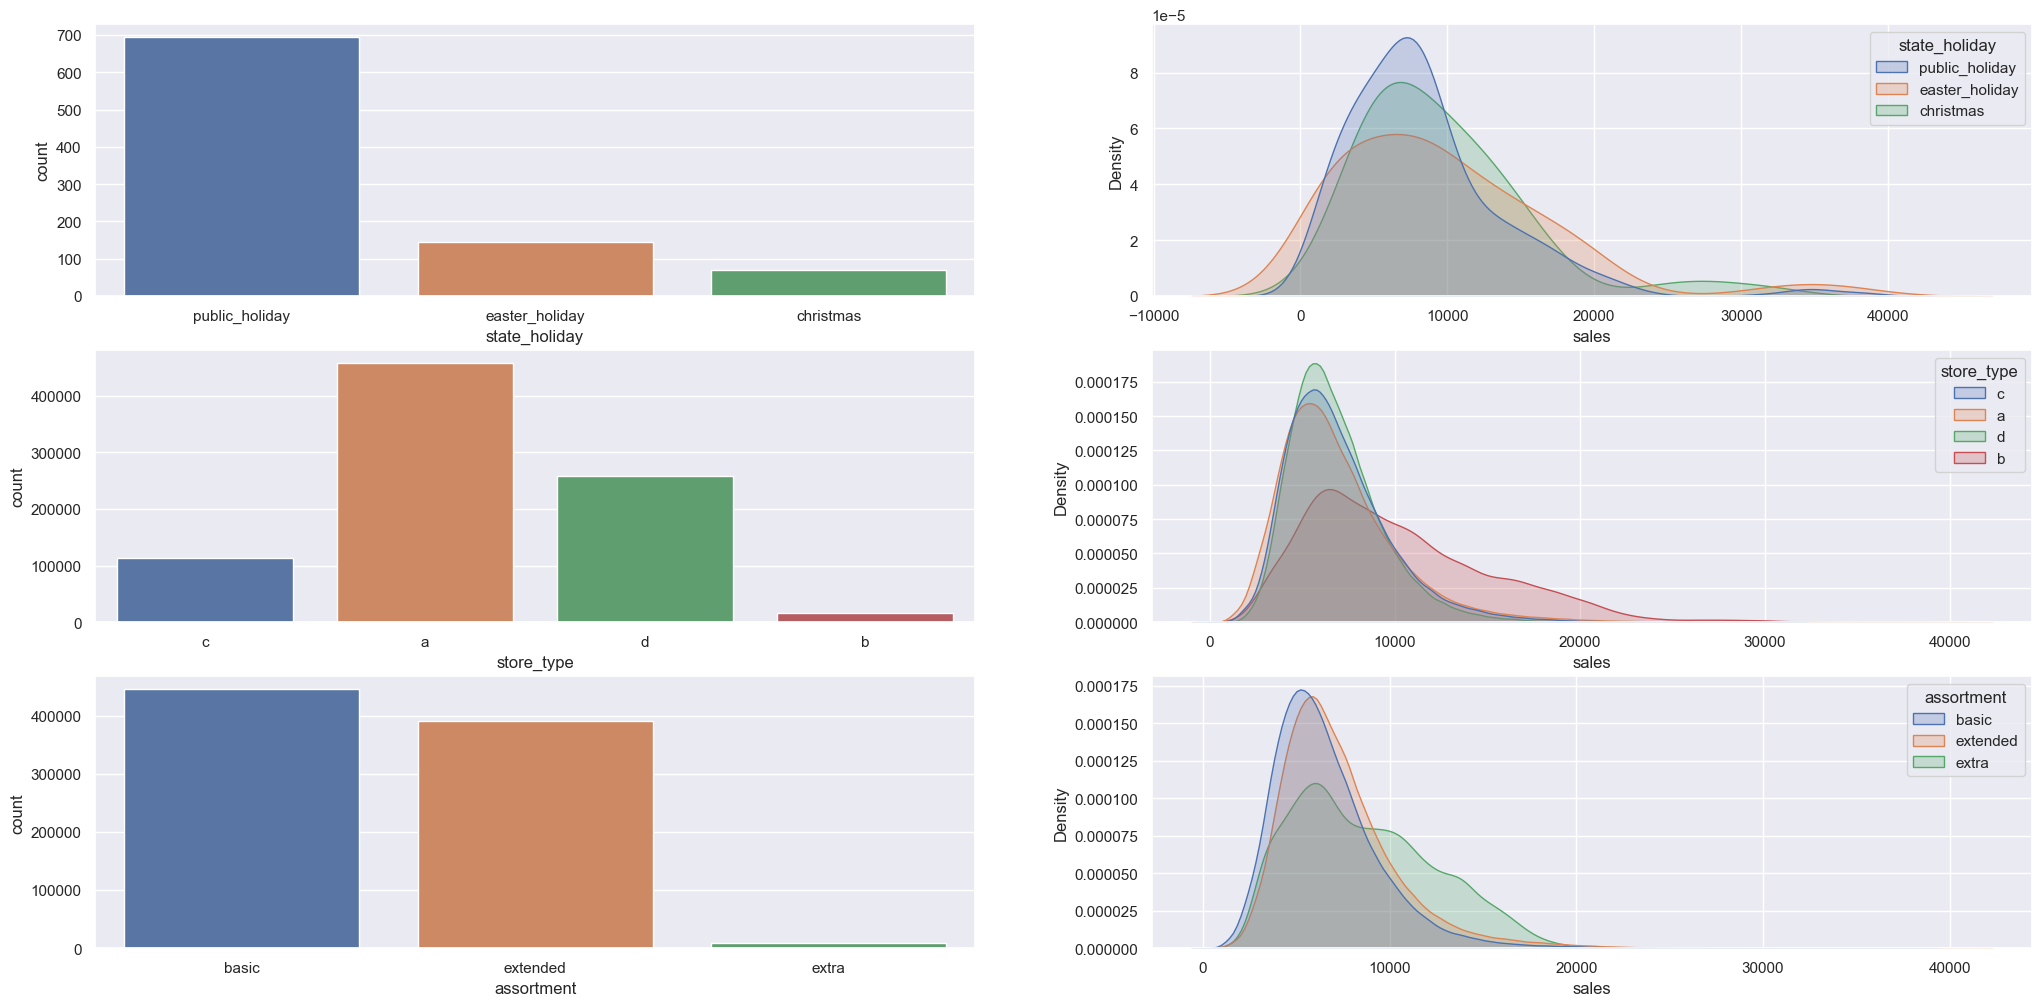

In [37]:
# Check the performance among the variables like holiday, store type and assortment

# State_holiday

plt.subplot(3, 2, 1)
a = df4[ df4['state_holiday'] != 'regular_day' ]
sns.countplot( x=a['state_holiday'] )

plt.subplot(3, 2, 2)
sns.kdeplot( data=a, x='sales', hue='state_holiday', fill=True, common_norm=False );

# Store_type

plt.subplot(3, 2, 3)
sns.countplot( x=df4['store_type'] );

plt.subplot(3, 2, 4)
sns.kdeplot( data=df4, x='sales', hue='store_type', fill=True, common_norm=False );

# Assortment

plt.subplot(3, 2, 5)
sns.countplot( x=df4['assortment'] )

plt.subplot(3, 2, 6)
sns.kdeplot( data=df4, x='sales', hue='assortment', fill=True, common_norm=False );


## Bivariate Analyse

### H1. Stores with the most assortment should sell more
**False** Stores with bigger assortment sell less

<AxesSubplot: xlabel='year_week'>

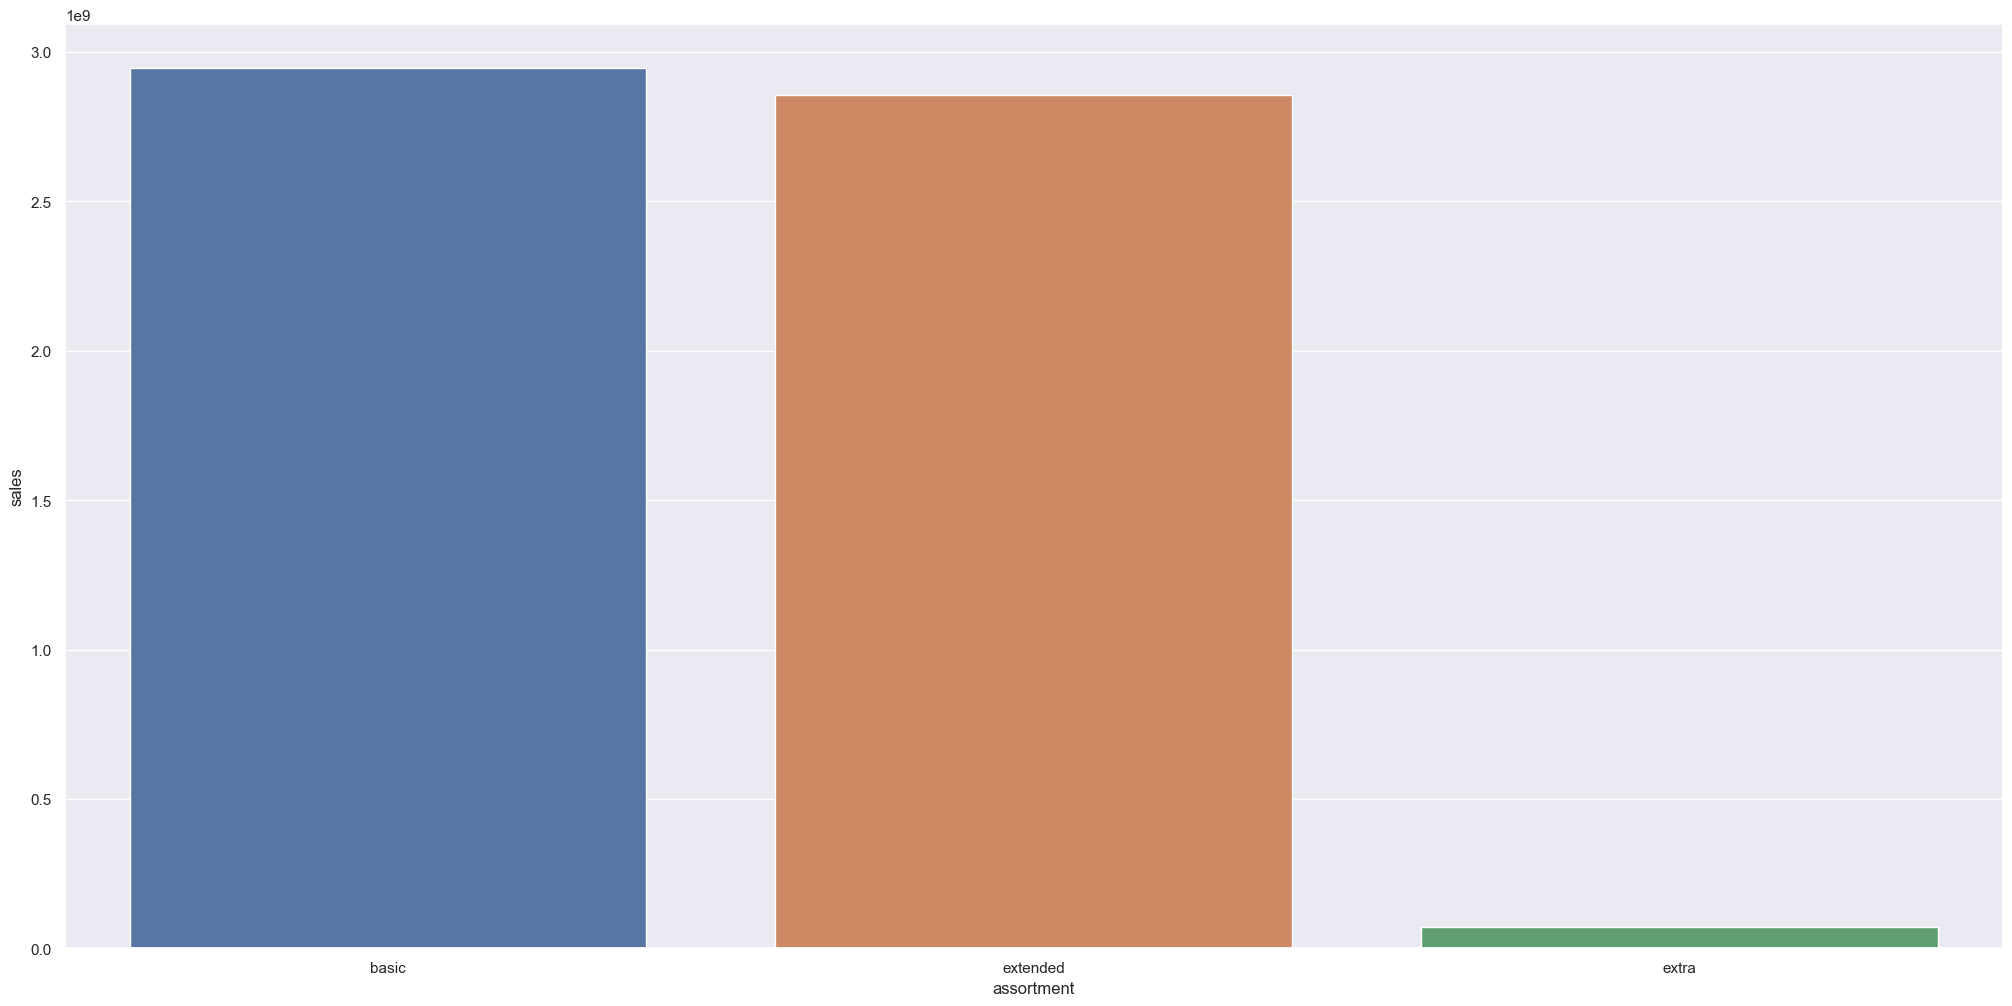

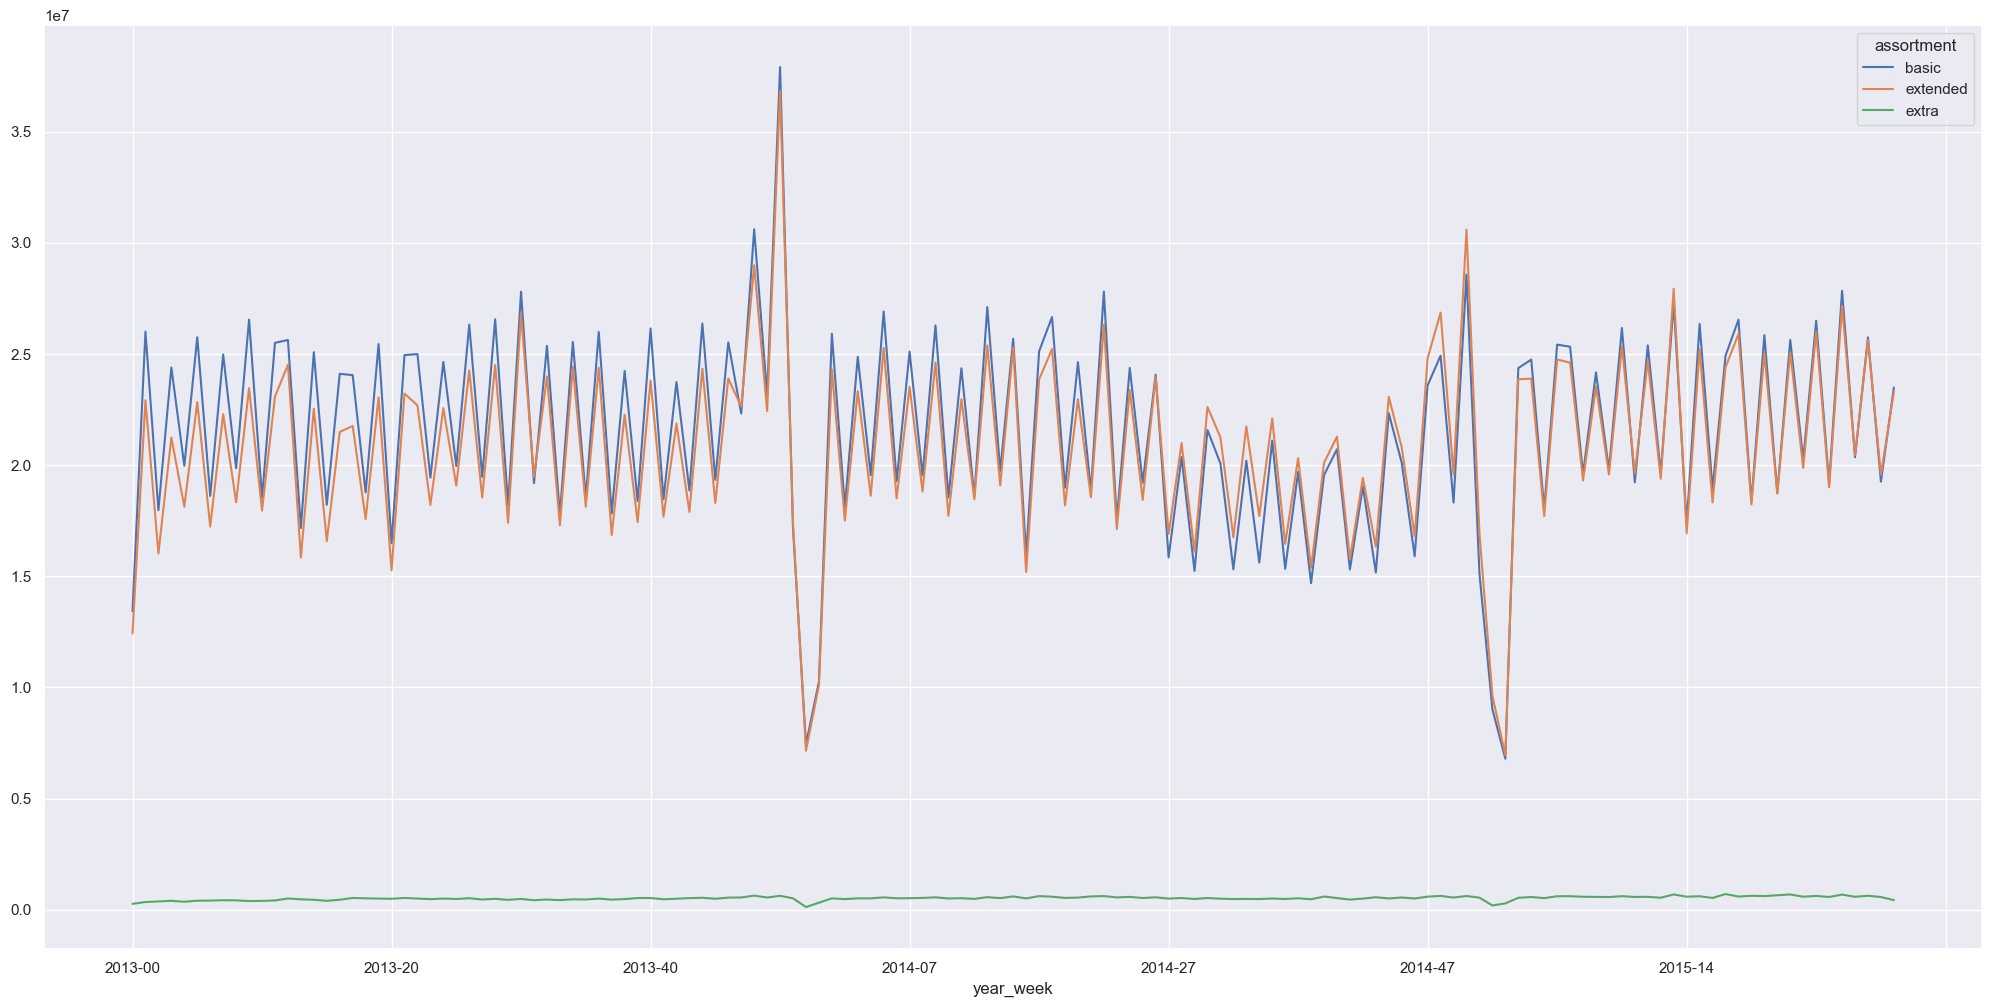

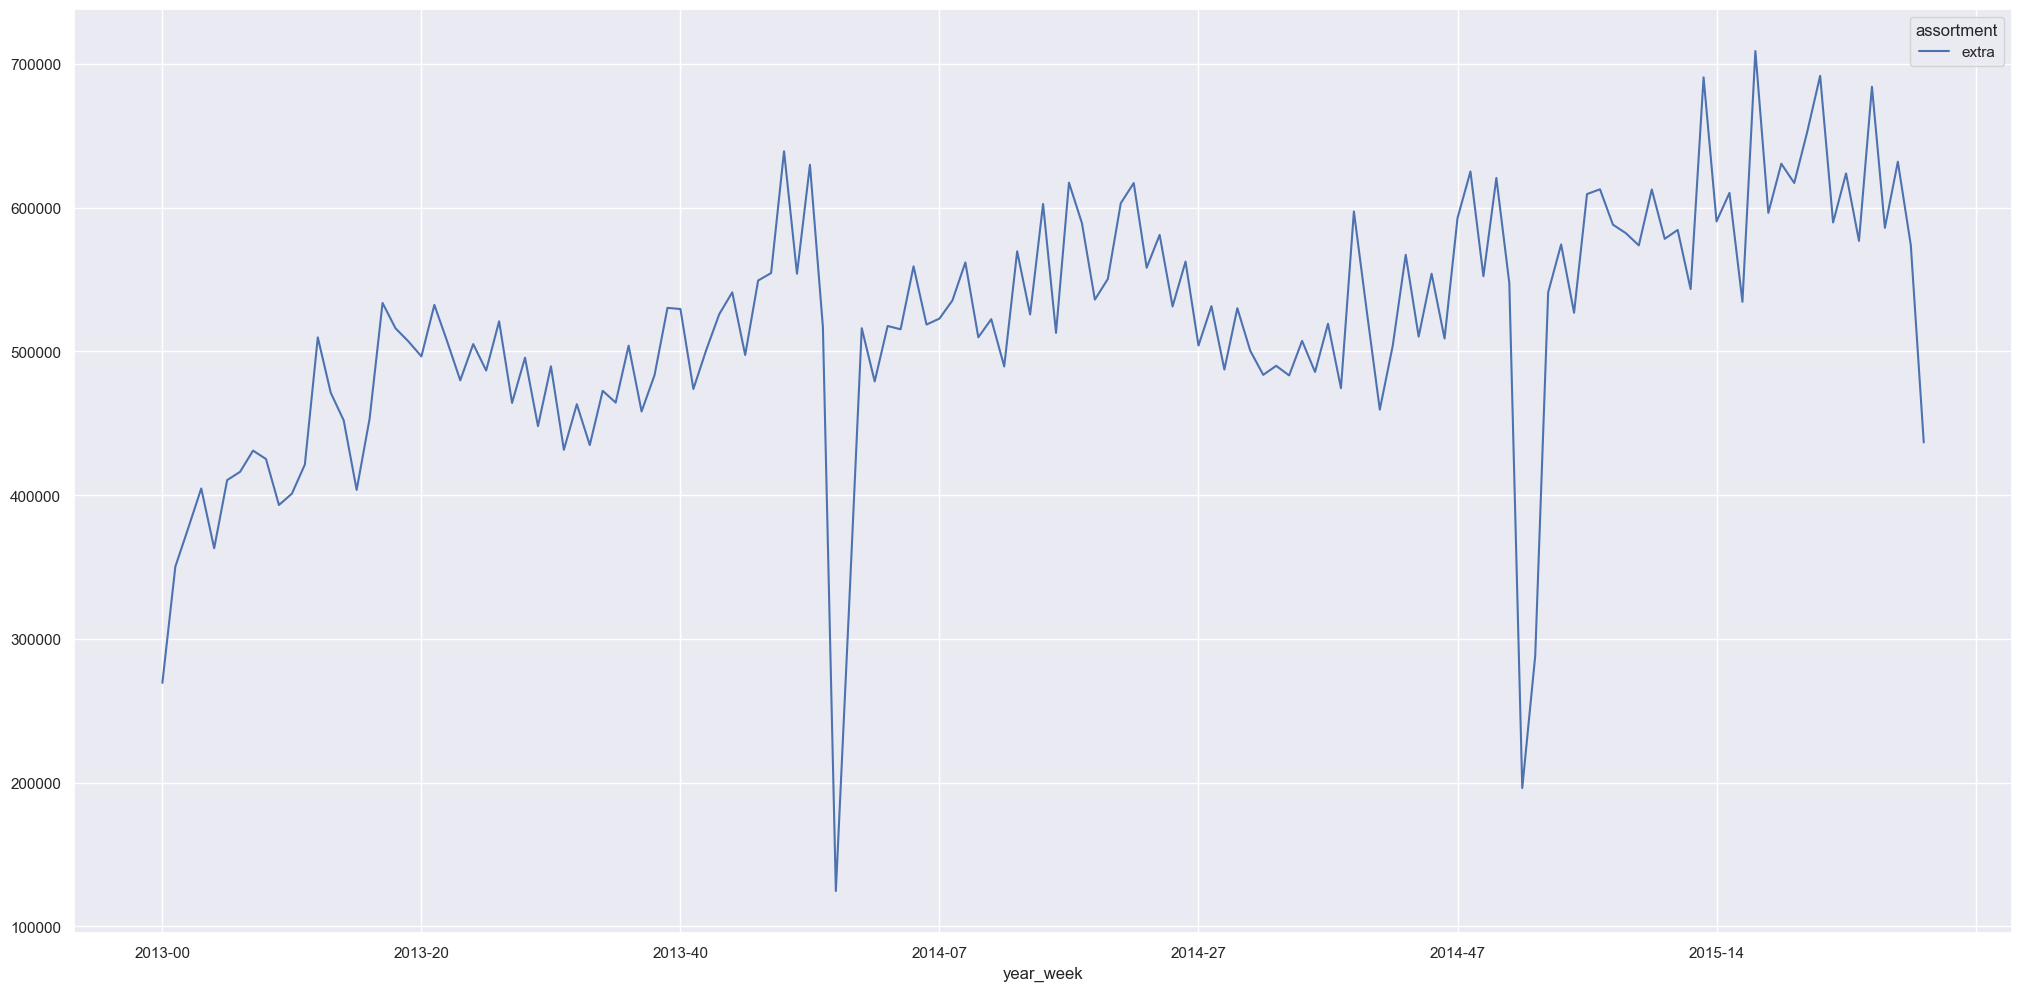

In [38]:
# Test if the Stores with bigger assortment sell more

# Group the segments, then sum their sales

aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

# Now let's see the behavior throughout the years

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

# We need to create one more chart to check the assortment (extra), because of its huge difference from the other two variable

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()


### H2. Stores with the closest competitors should sell less
**False** Stores with closest competitors sell more

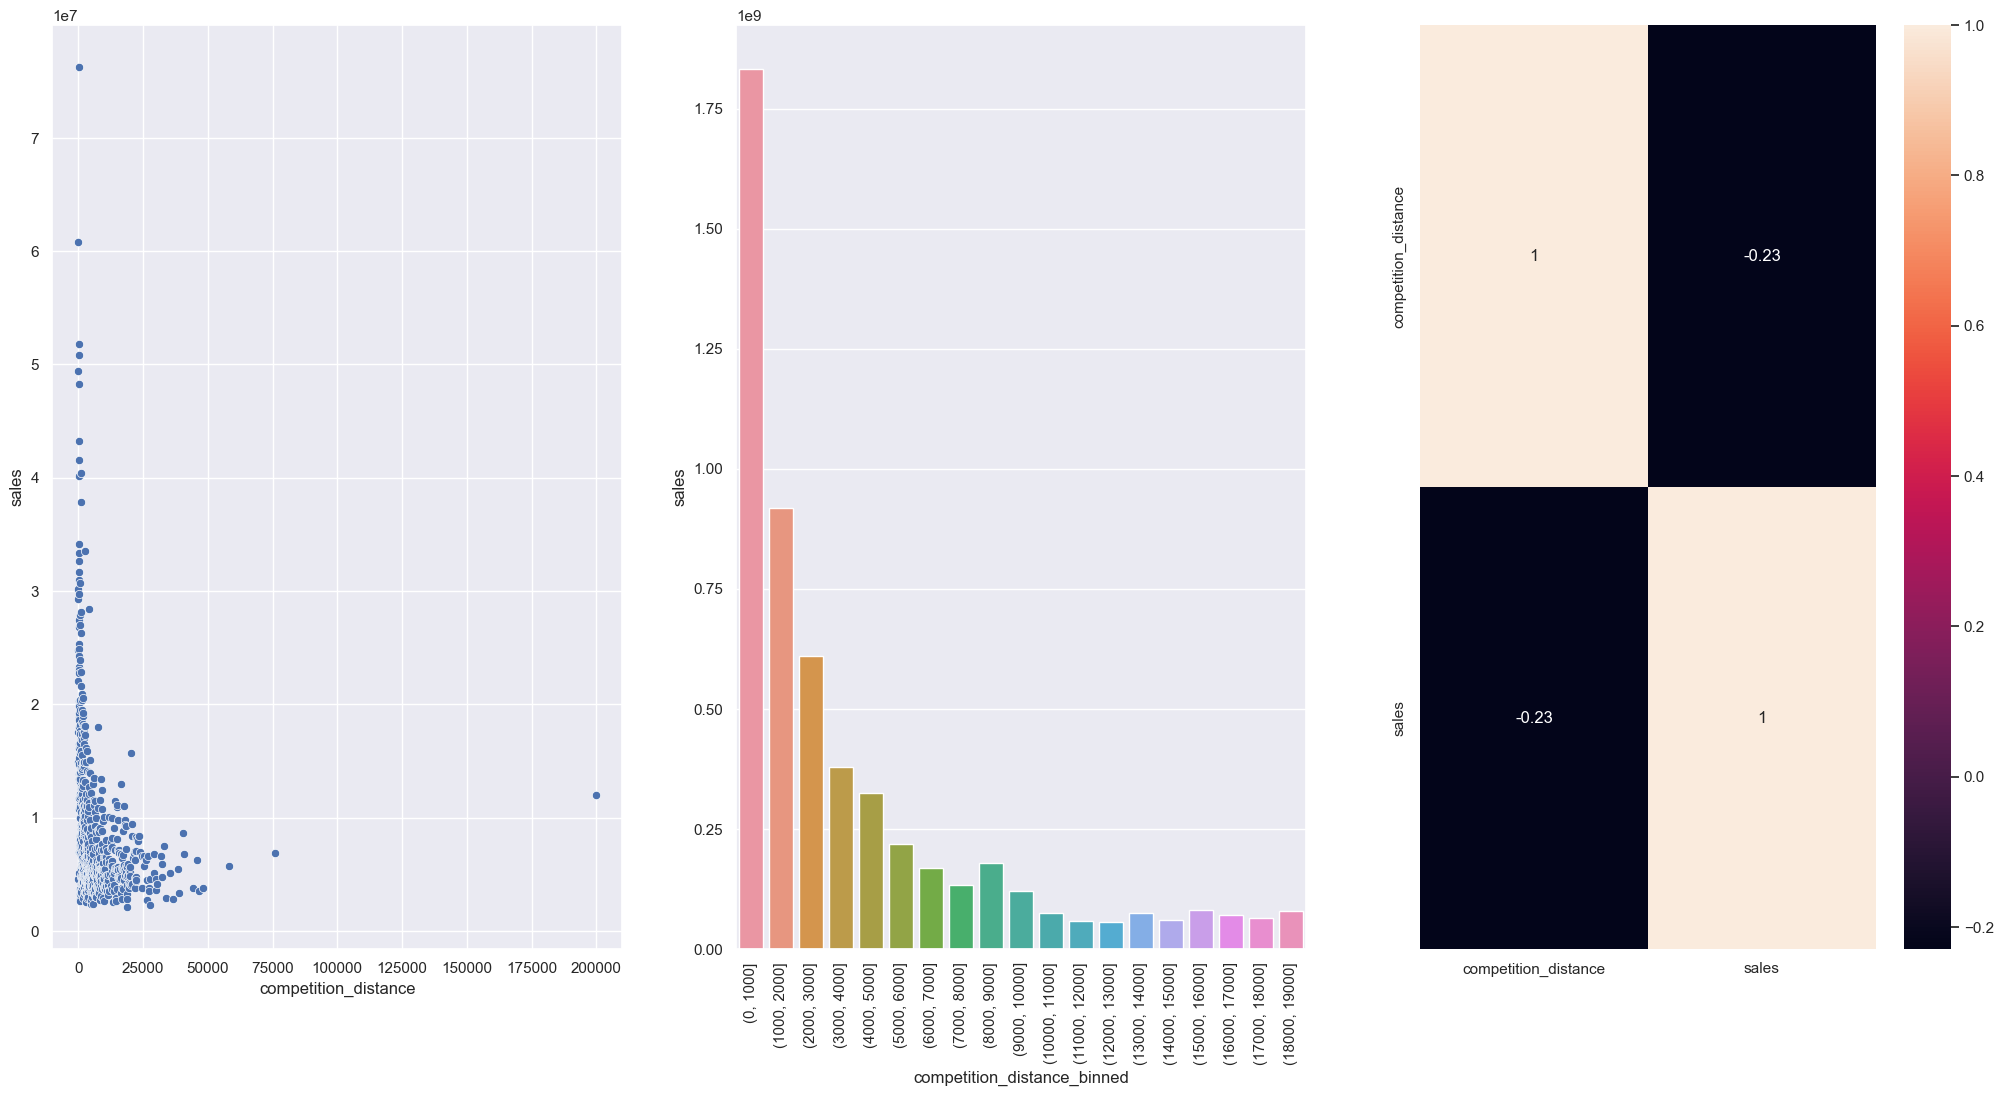

In [39]:
# Check the relation between sales and competition distance

aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

# Scatterplot help us to show the distribution of sales in the various distance range

plt.subplot(1, 3, 1)
sns.scatterplot( x='competition_distance', y='sales', data=aux1 );

# Let's create a more visible chart, Bins make the data divided in groups to have more visibility

plt.subplot(1, 3, 2)
bins = list( np.arange(0, 20000, 1000) )

aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );

# Rotate the x label to be alble to see the subtitles

plt.xticks( rotation=90 );

# Correlation Pearson

plt.subplot(1, 3, 3)
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );


### H3. Stores with the oldest competitors should sell more
**False** Stores with oldest competitors sell less

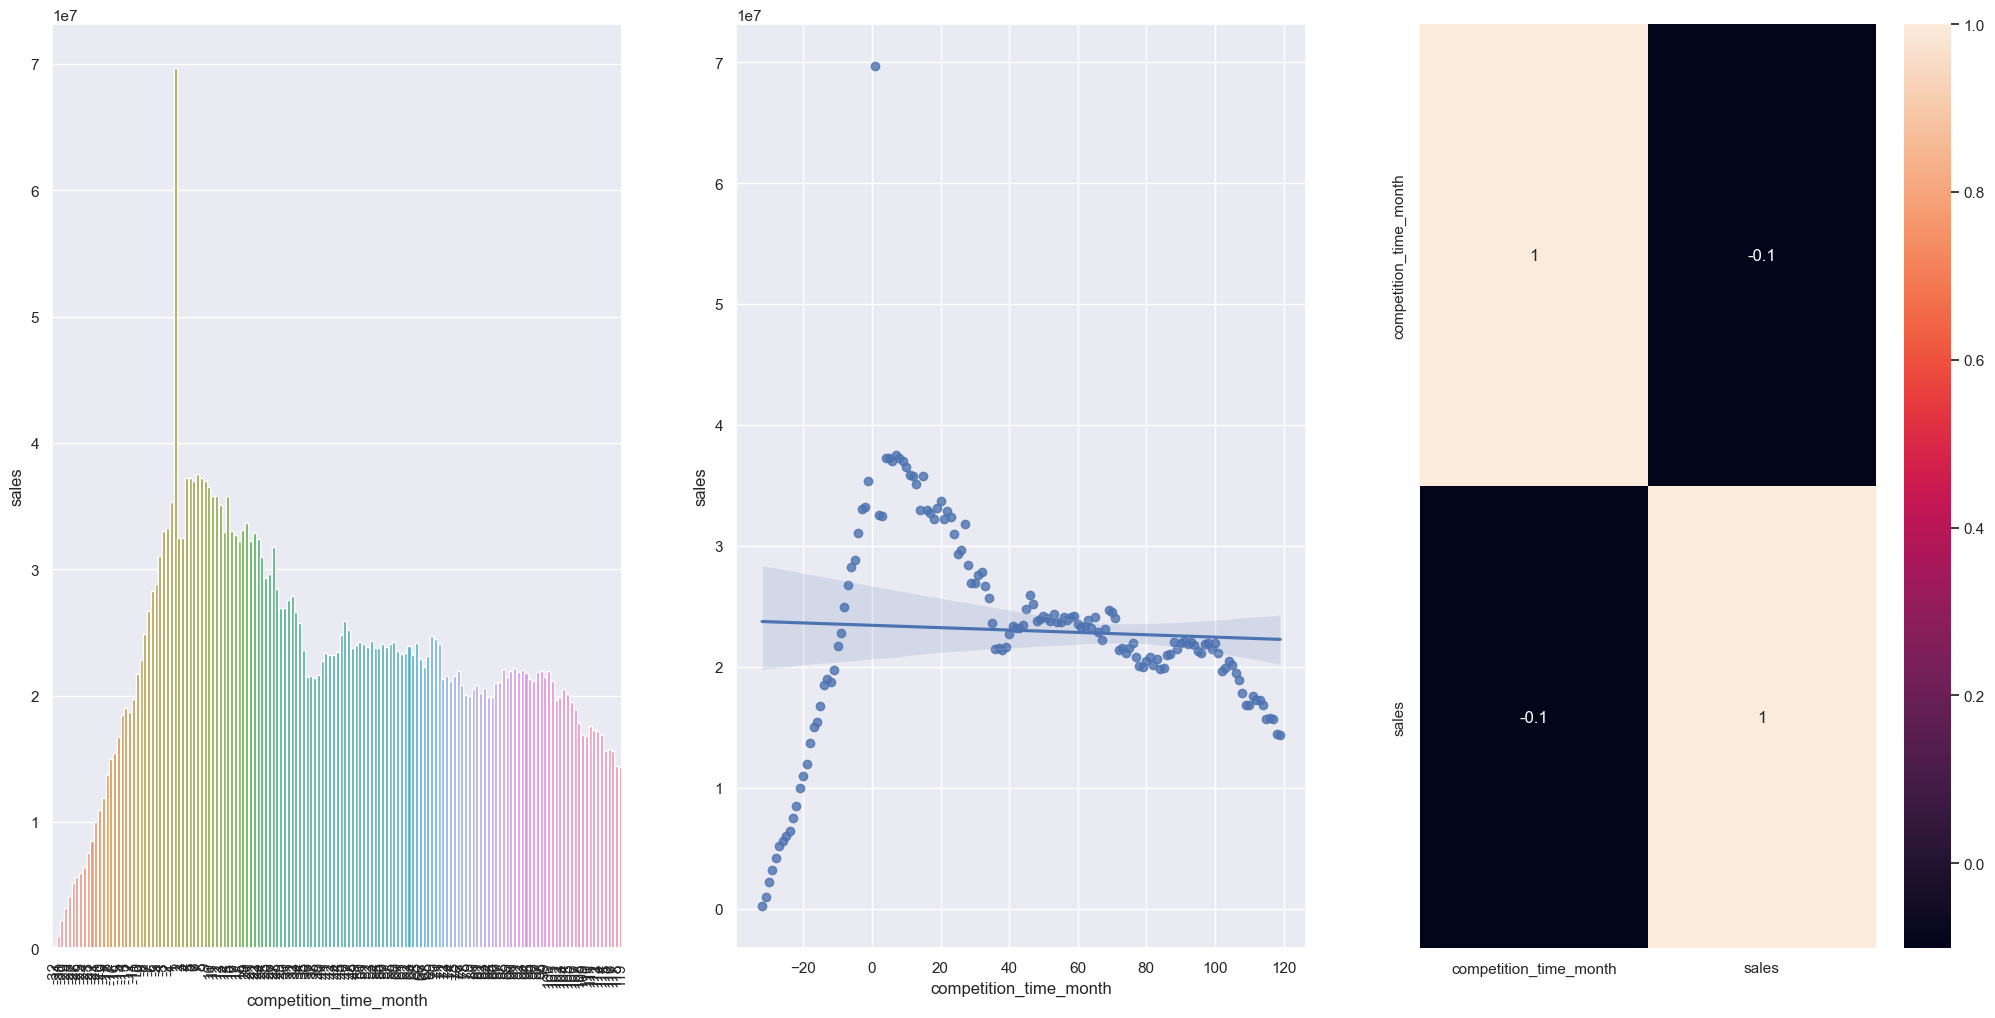

In [40]:
# Group the competition by time to its influence in the sales

plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()

# Make a filter competition time that retuns a max 120 months and different from 0
    
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot(1, 3, 2)
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot(1, 3, 3)
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );


### H4. Stores with active discount for a longer time should sell more
**False** Stores with active discount for a longer time sell less after a certain time

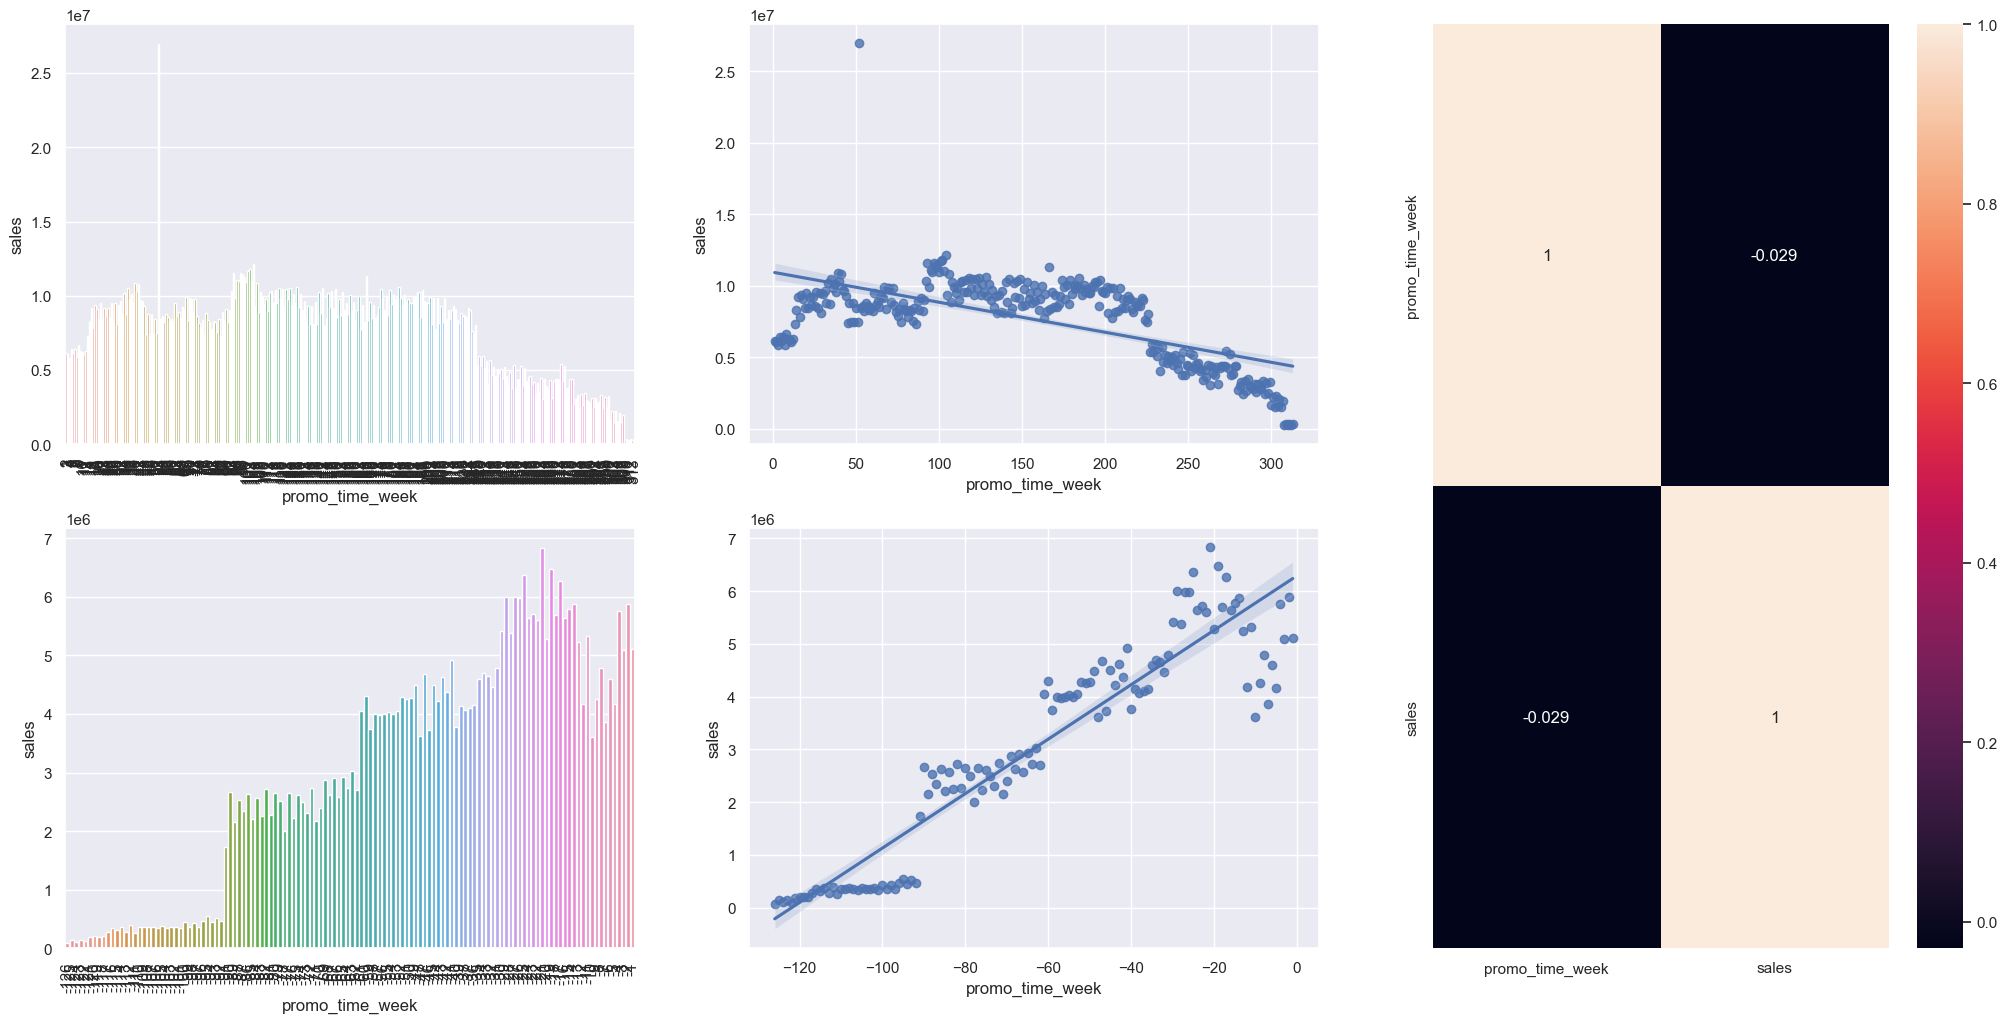

In [41]:
# check how the promo time affects the sales

aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()

# Create a Grid

grid = GridSpec(2, 3)

plt.subplot( grid[0,0] )

aux2 = aux1[aux1['promo_time_week'] > 0] # Extended Promo
sns.barplot( x='promo_time_week', y='sales', data= aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0, 1] )

sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1, 0] )
aux3 = aux1[aux1['promo_time_week'] < 0 ] # Regular Promo
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson'), annot=True );


### <s>**H5.** Stores with the most days on sale should sell more</s>

### H6. Stores with frequent discounts should sell more
**False** Stores which stay on sales more often sell less

In [42]:
# Check how much the stores with and without discount have sold

df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().sort_values('sales', ascending=False).reset_index()


,promo,promo2,sales
0,1,0,1628930532
1,0,0,1482612096
2,1,1,1472275754
3,0,1,1289362241


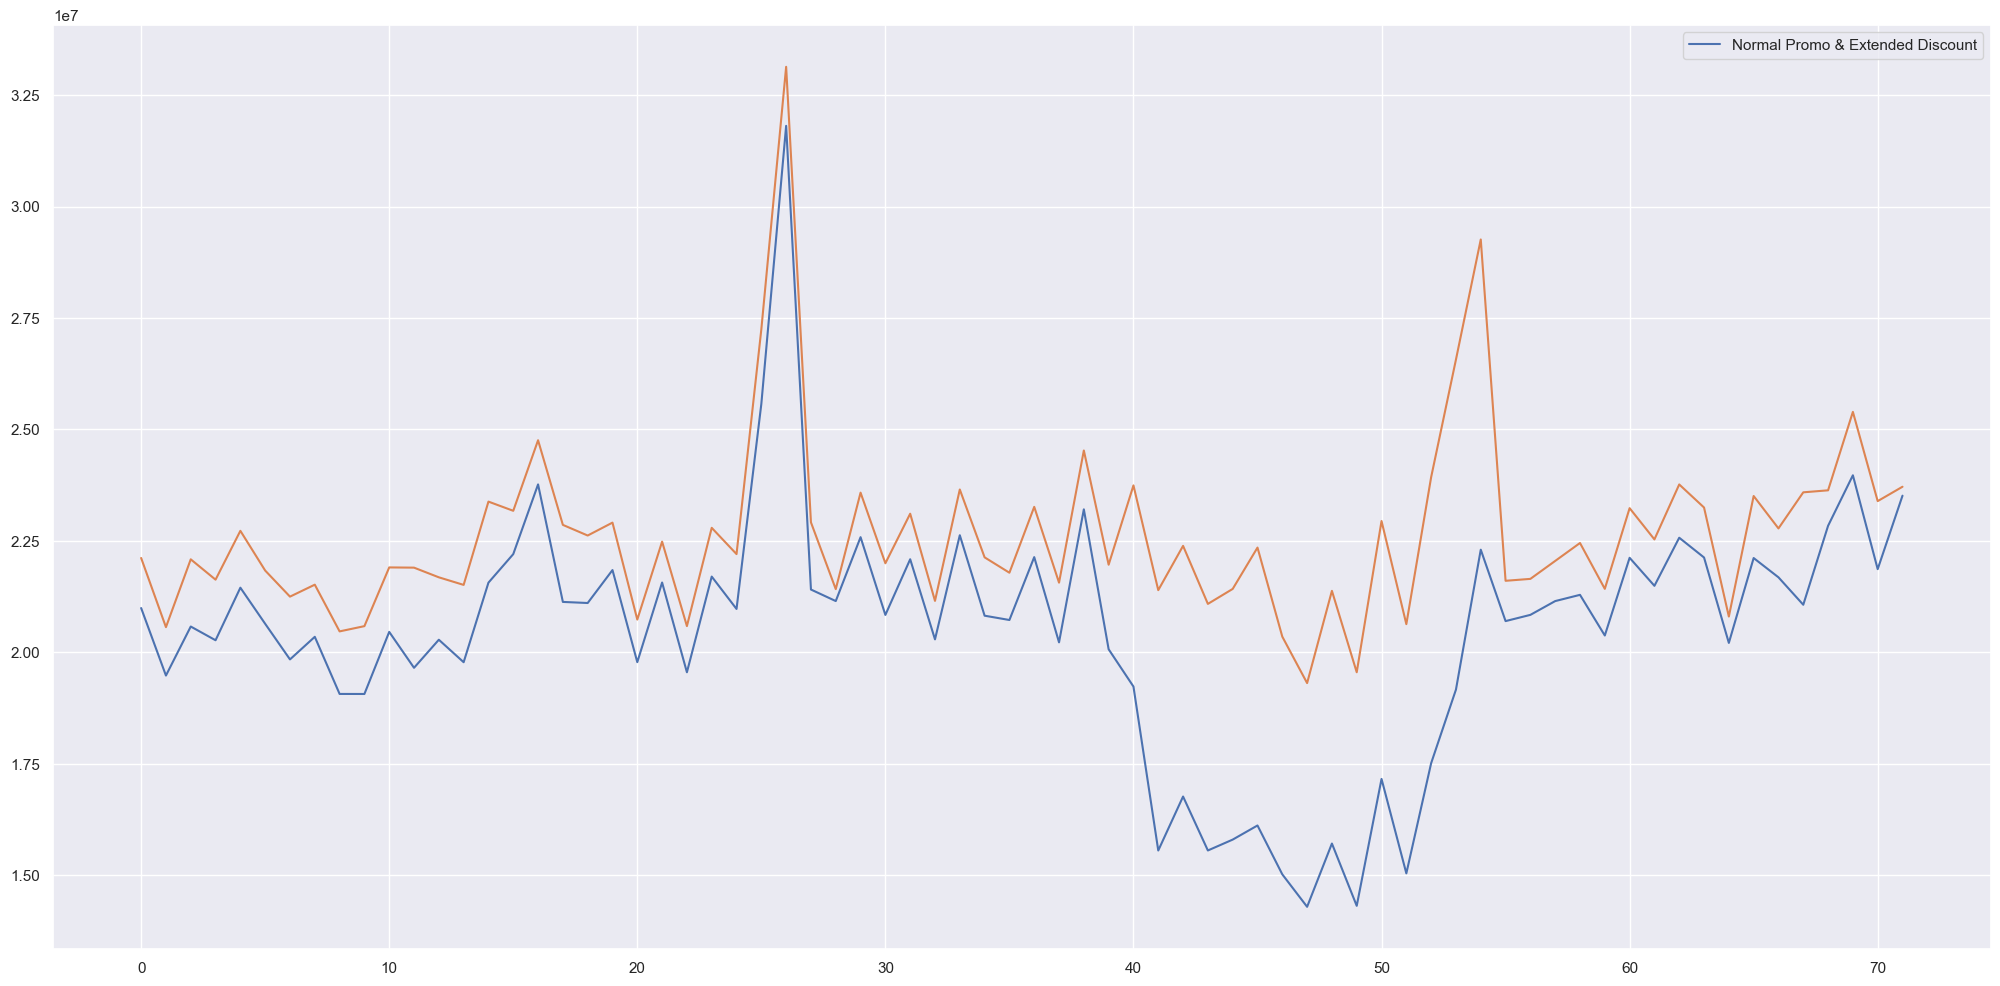

In [43]:
# Nos let's check the perfomance thorughout time

aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Normal Promo & Extended Discount'] );


### H7. Stores should sell more during Christmas
**False** Store sell less on Christmas

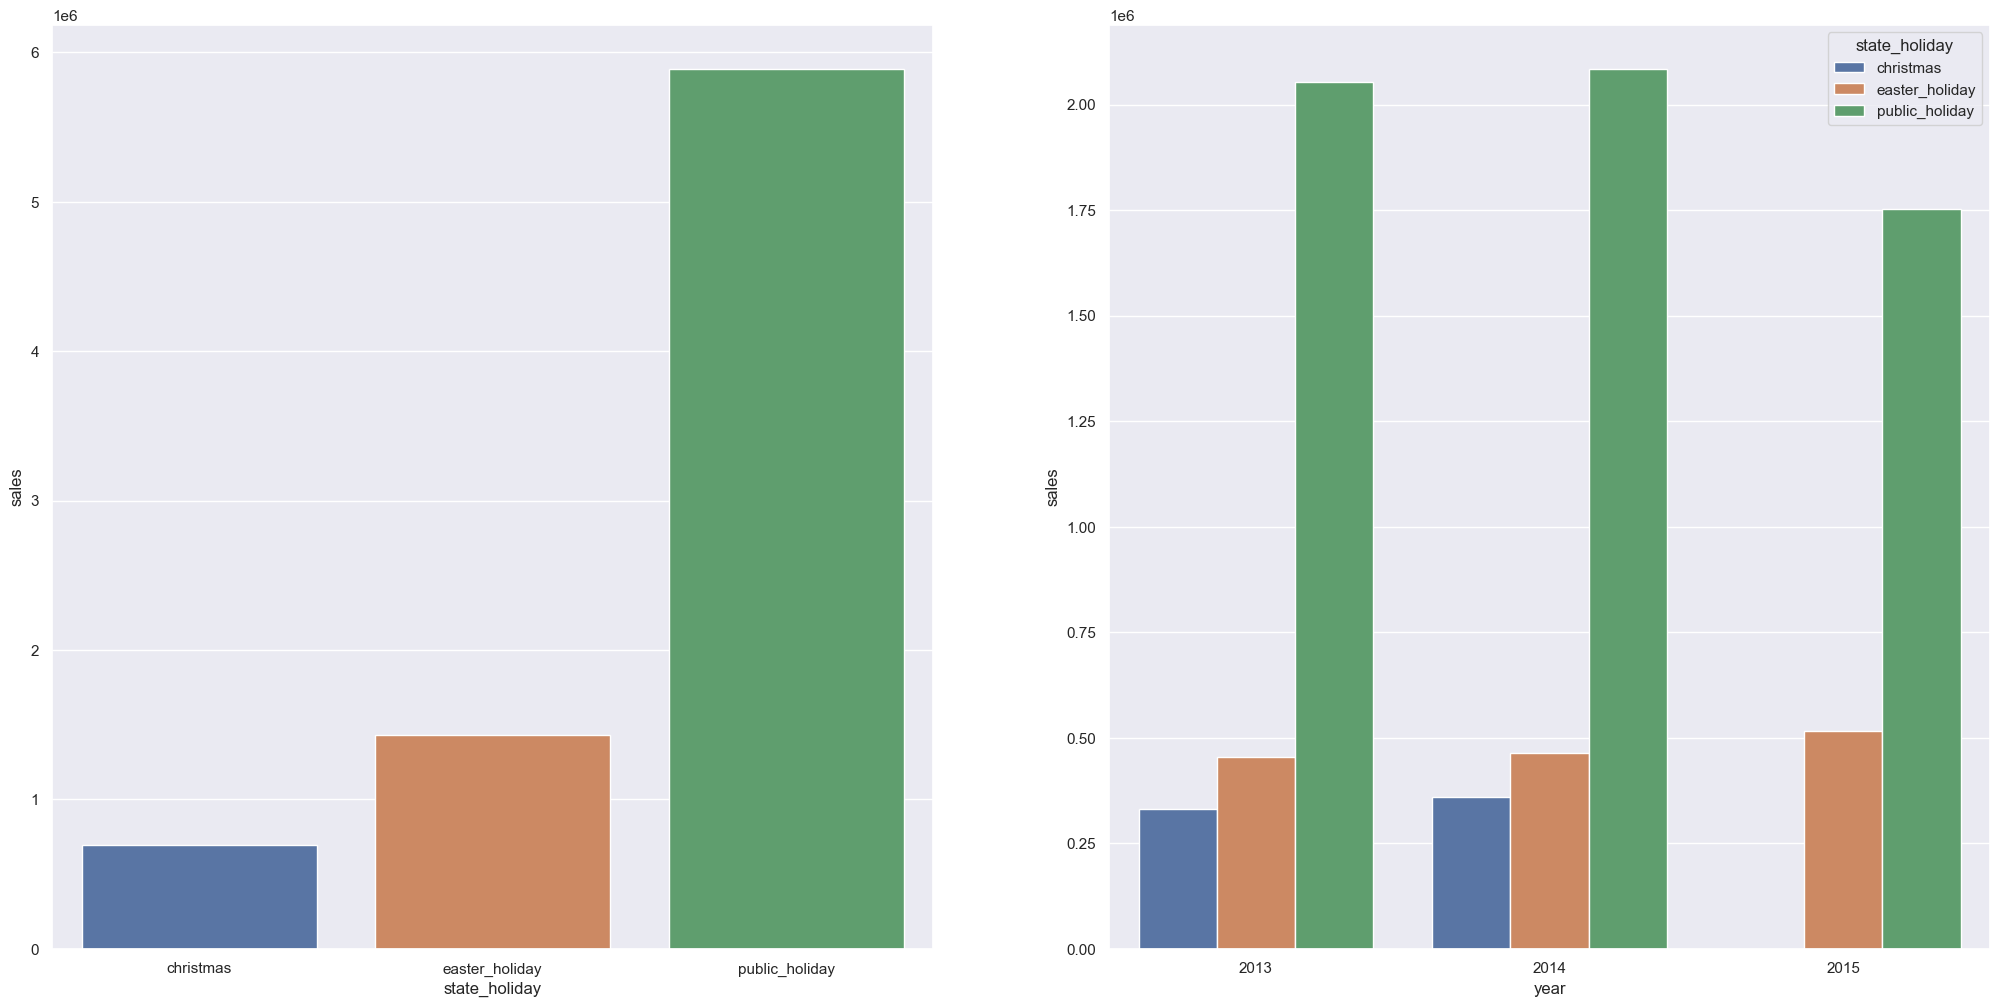

In [44]:
# Filter the Holiday

aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );


### **H8.** Stores should sell more throughout the years
**False** Stores sell less throughout the years

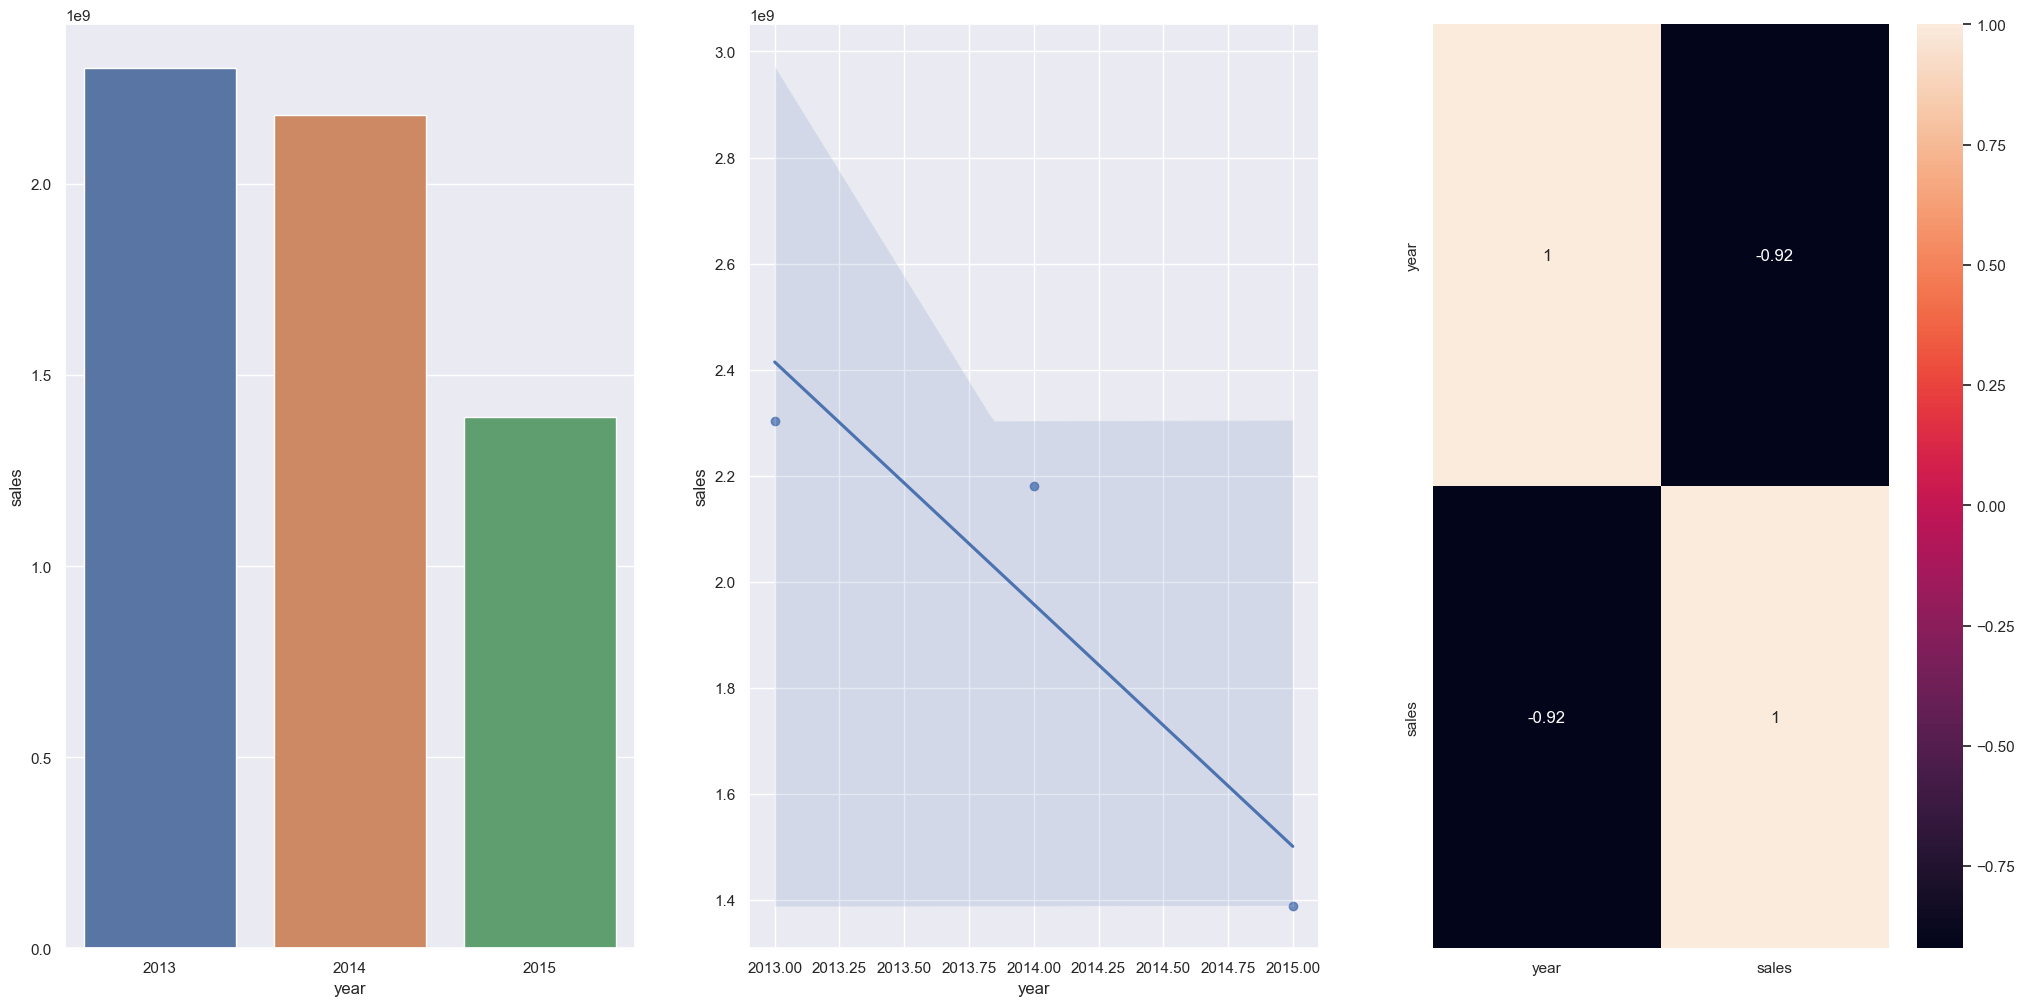

In [45]:
# Group the sales in the years, (Note that the last year wasn't completed)

aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot(1, 3, 2)
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );


### H9. Stores should sell more in the second semester
**False** Stores sell less in the second semester

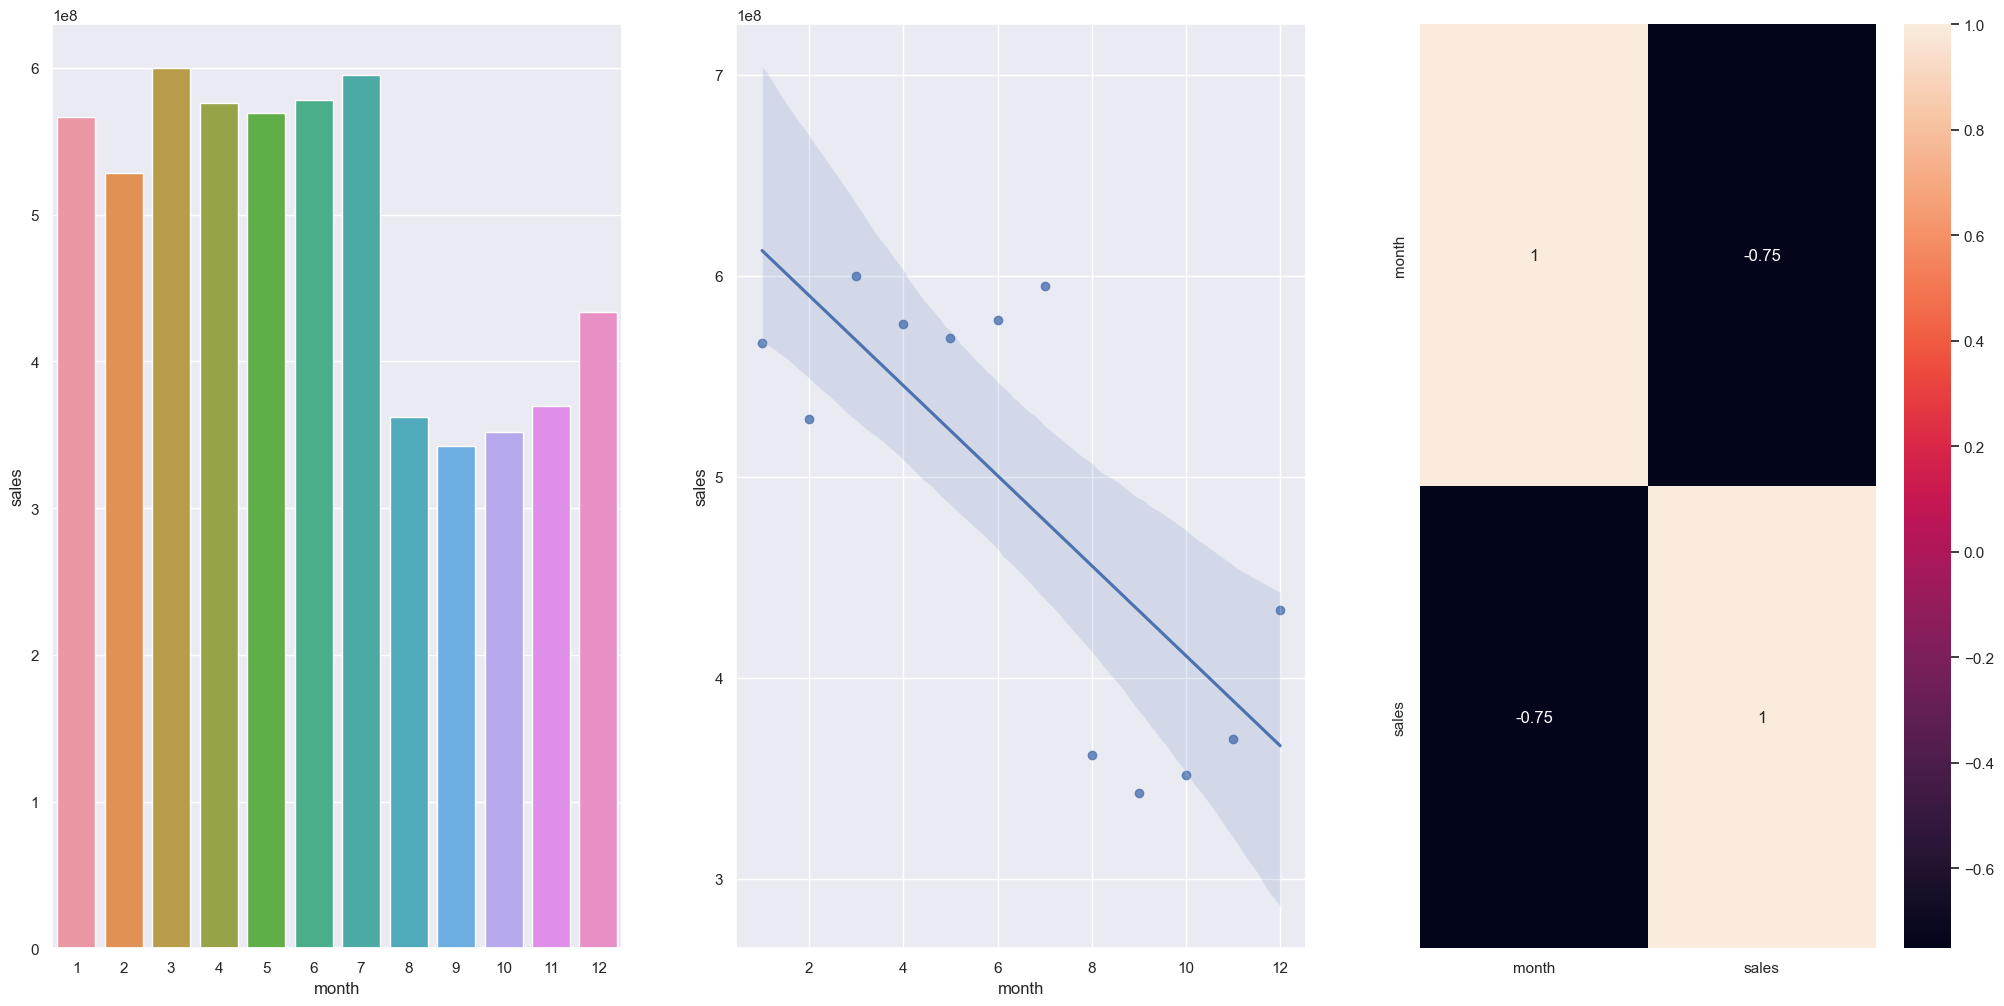

In [46]:
# Let's Group the sales in months, then we can see the behavior troughout the year.

aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot(1, 3, 2)
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );


### H10. Stores should sell more after the 10th of each month
**True** Stores sell more after the 10th day of each month

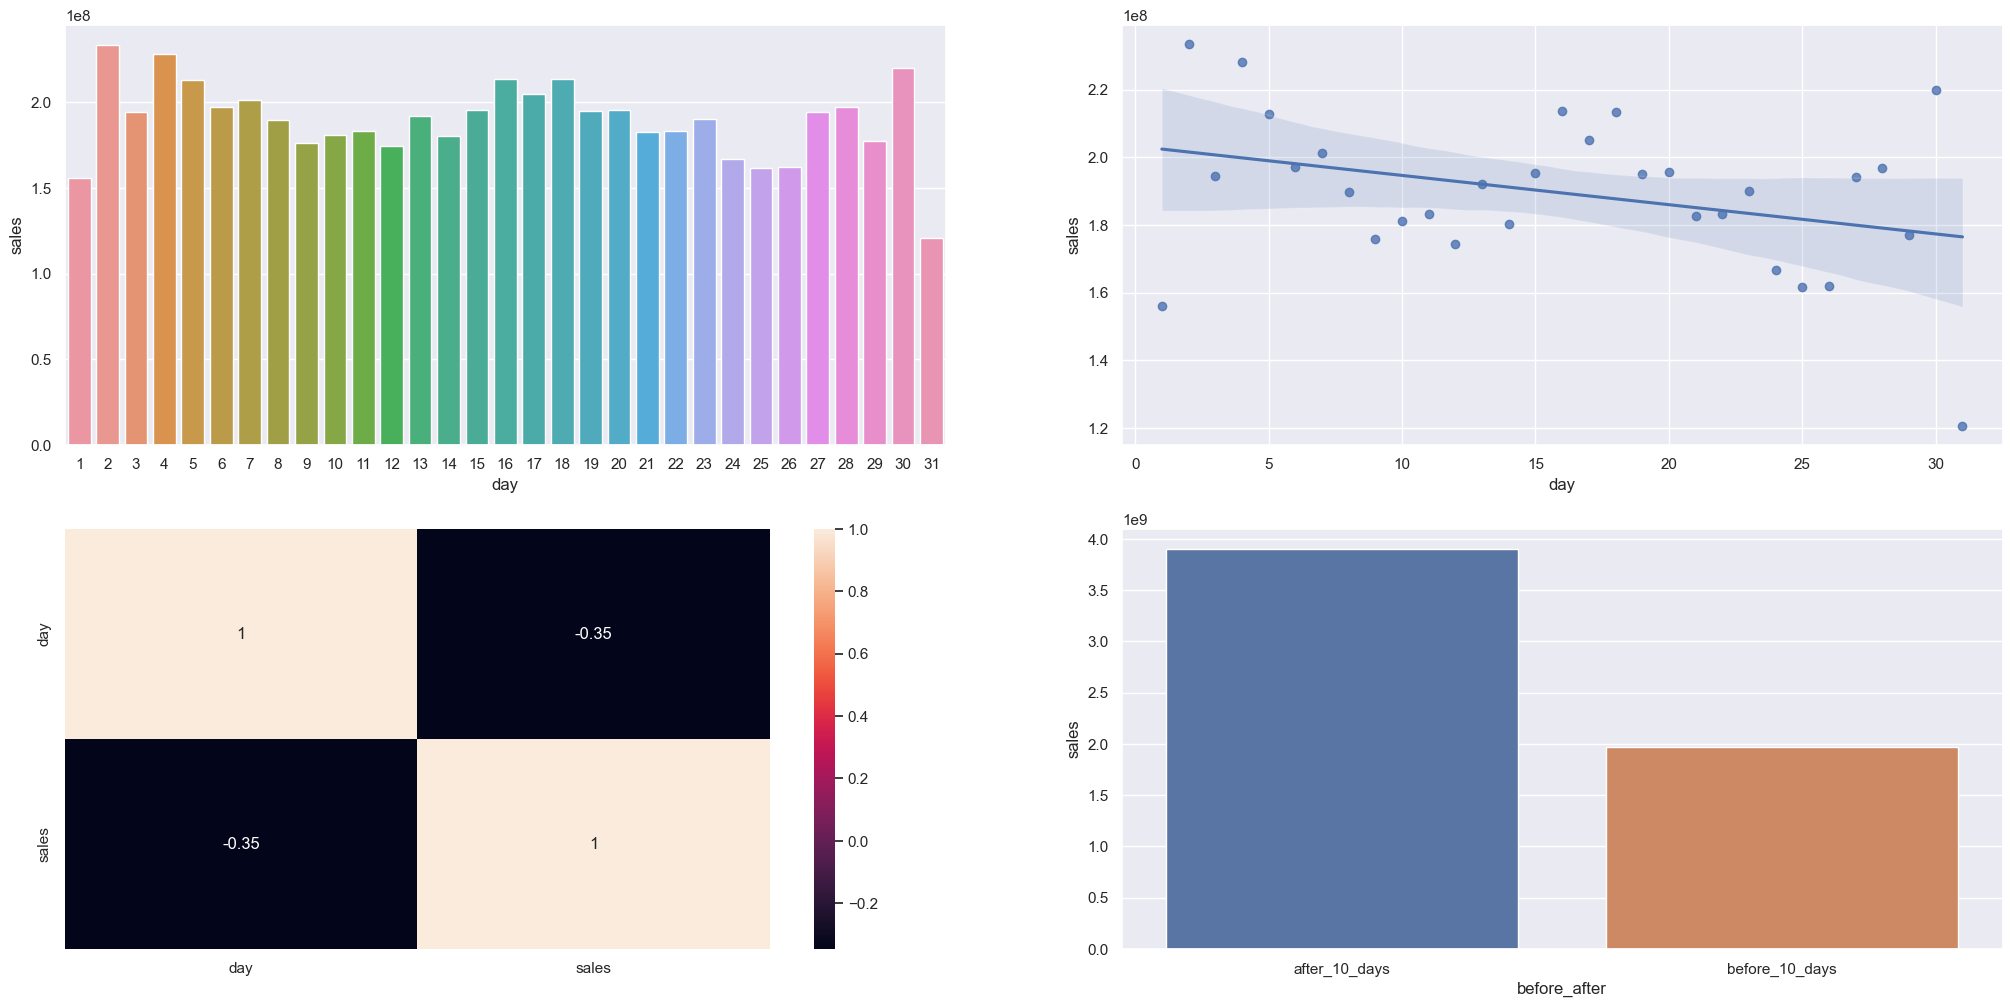

In [47]:
# Group the sales in each day of the month

aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot(2, 2, 2)
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot(2, 2, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

# Filter in two groups, before day 10 and after day 10

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot( x='before_after', y='sales', data=aux2 );


### H11. Stores should sell less in the weekends
**True** Stores sell less in the weekend

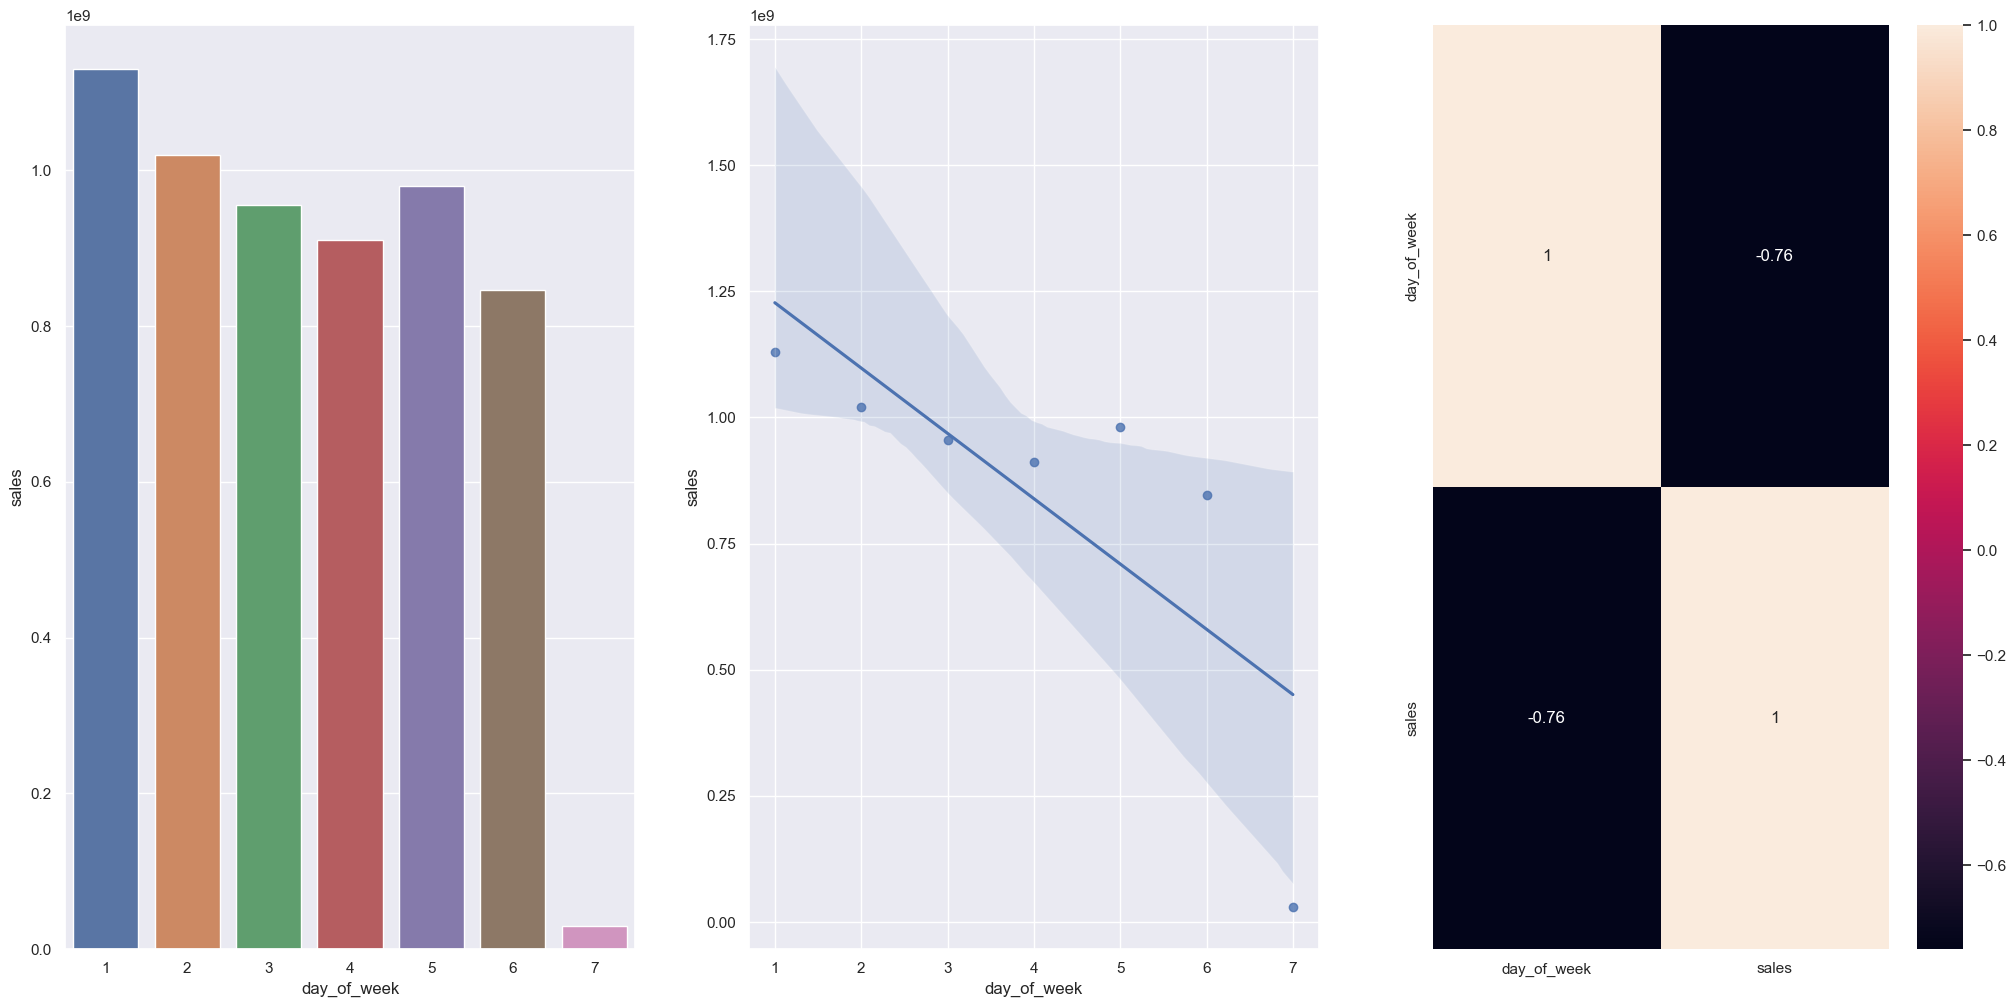

In [48]:
# Group the sales by day

aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot(1, 3, 2)
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True );


### H12. Stores should sell less during scholar holidays
**True** Stores sell less during the scholar holidays but in August, and july we have almost the same number

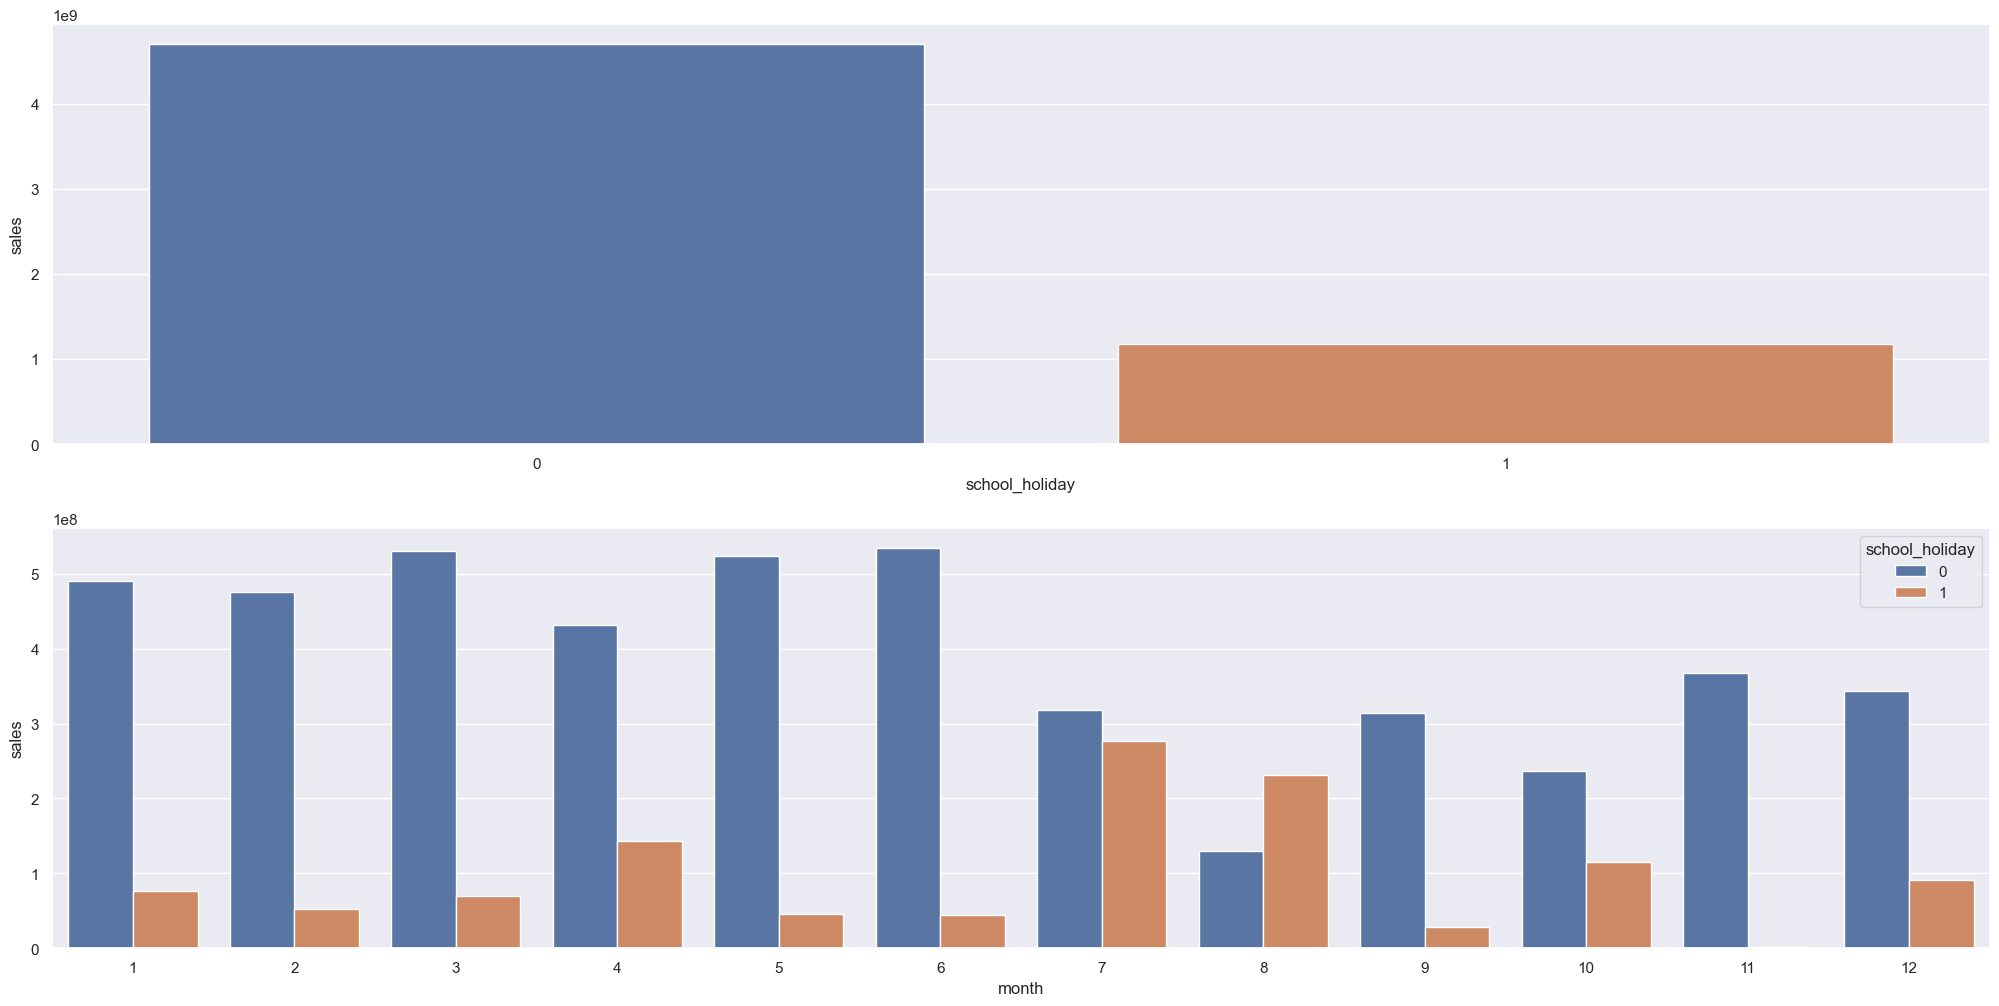

In [49]:
# Group by school holiday yes or not

aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

plt.subplot(2, 1, 1)
sns.barplot( x='school_holiday', y='sales', data=aux1 );

# filter deeper to see the diferrence throughout the months

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()

plt.subplot(2, 1, 2)
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );


### Hypothesis Results

In [50]:
# Check the charts we made, and see how influent is each variable regarding the variable response (sales)

tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Media'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )


Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


##  Multiple Analyse

### Numerical Attributes

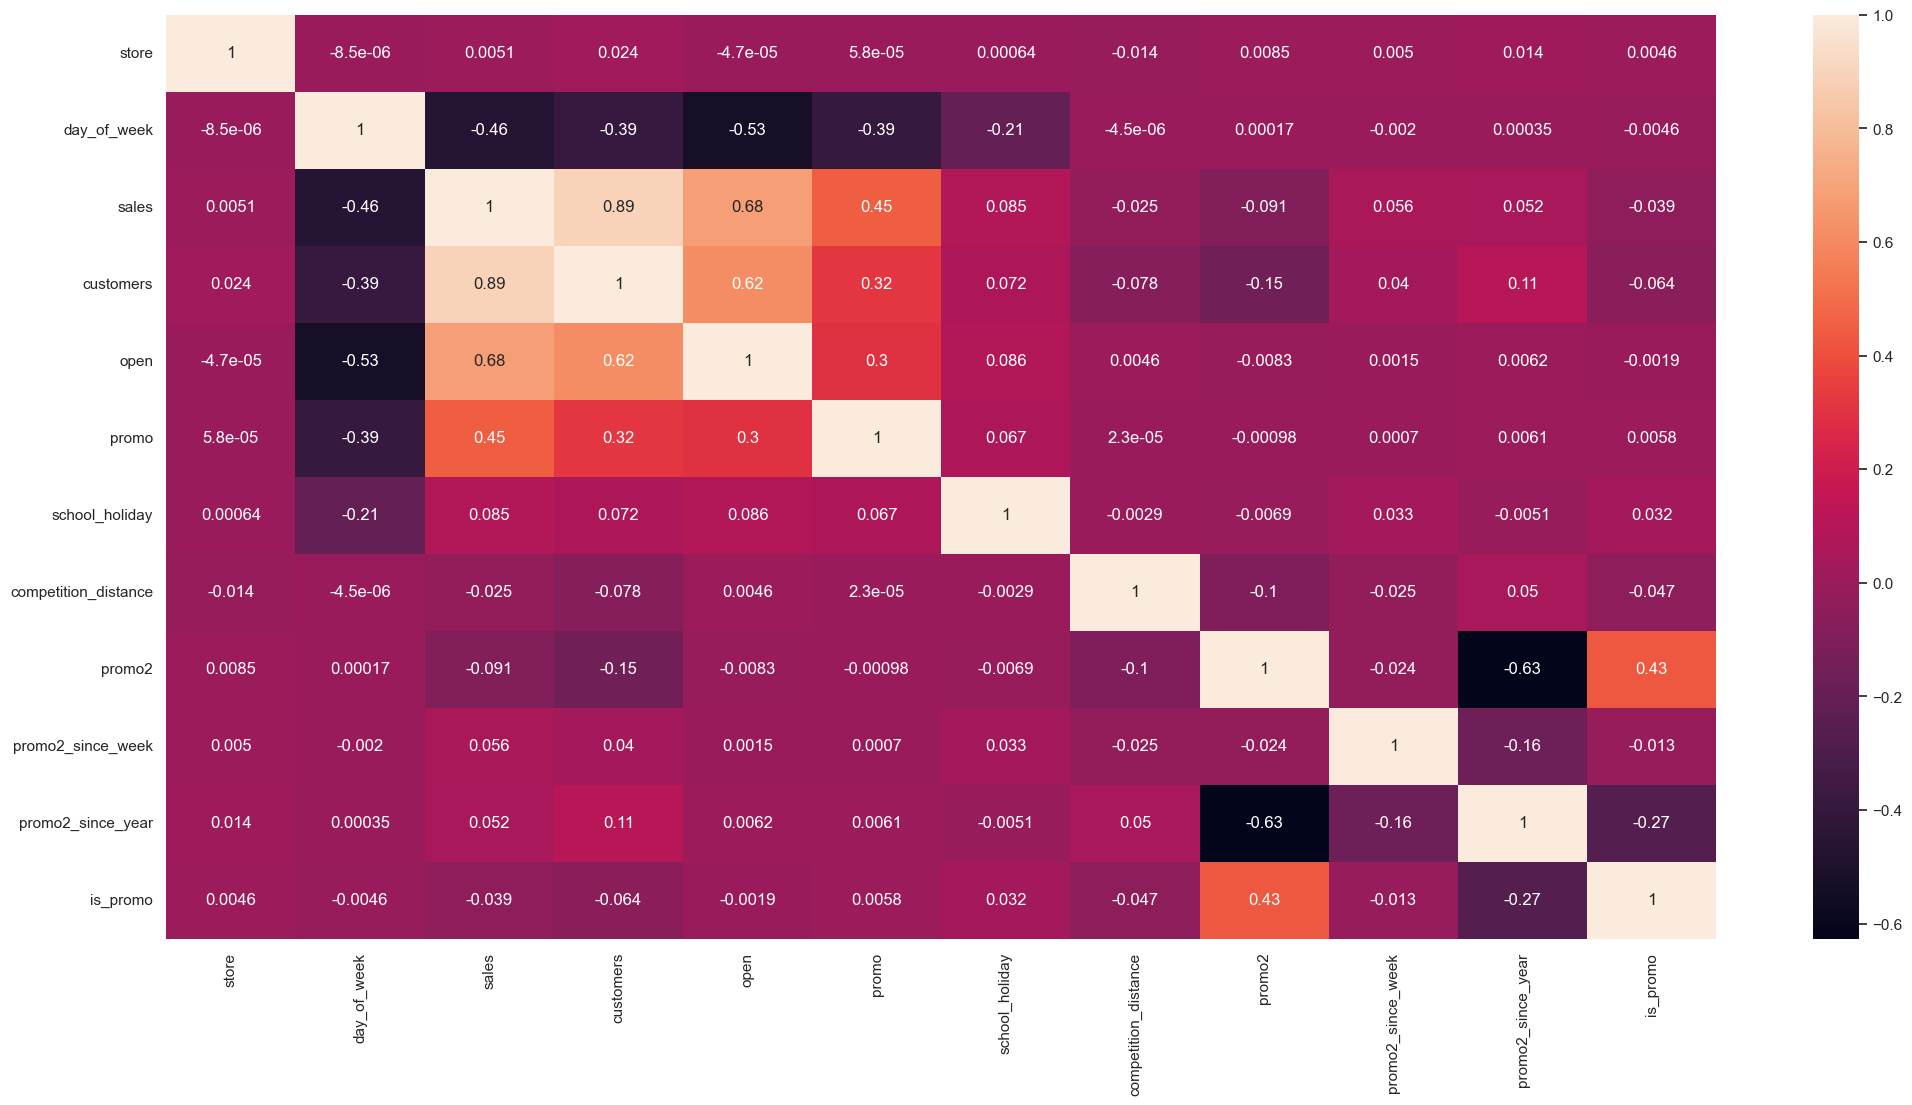

In [51]:
# Check all the correlations among the Numerical Variables

correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );


### Categorical Attributes

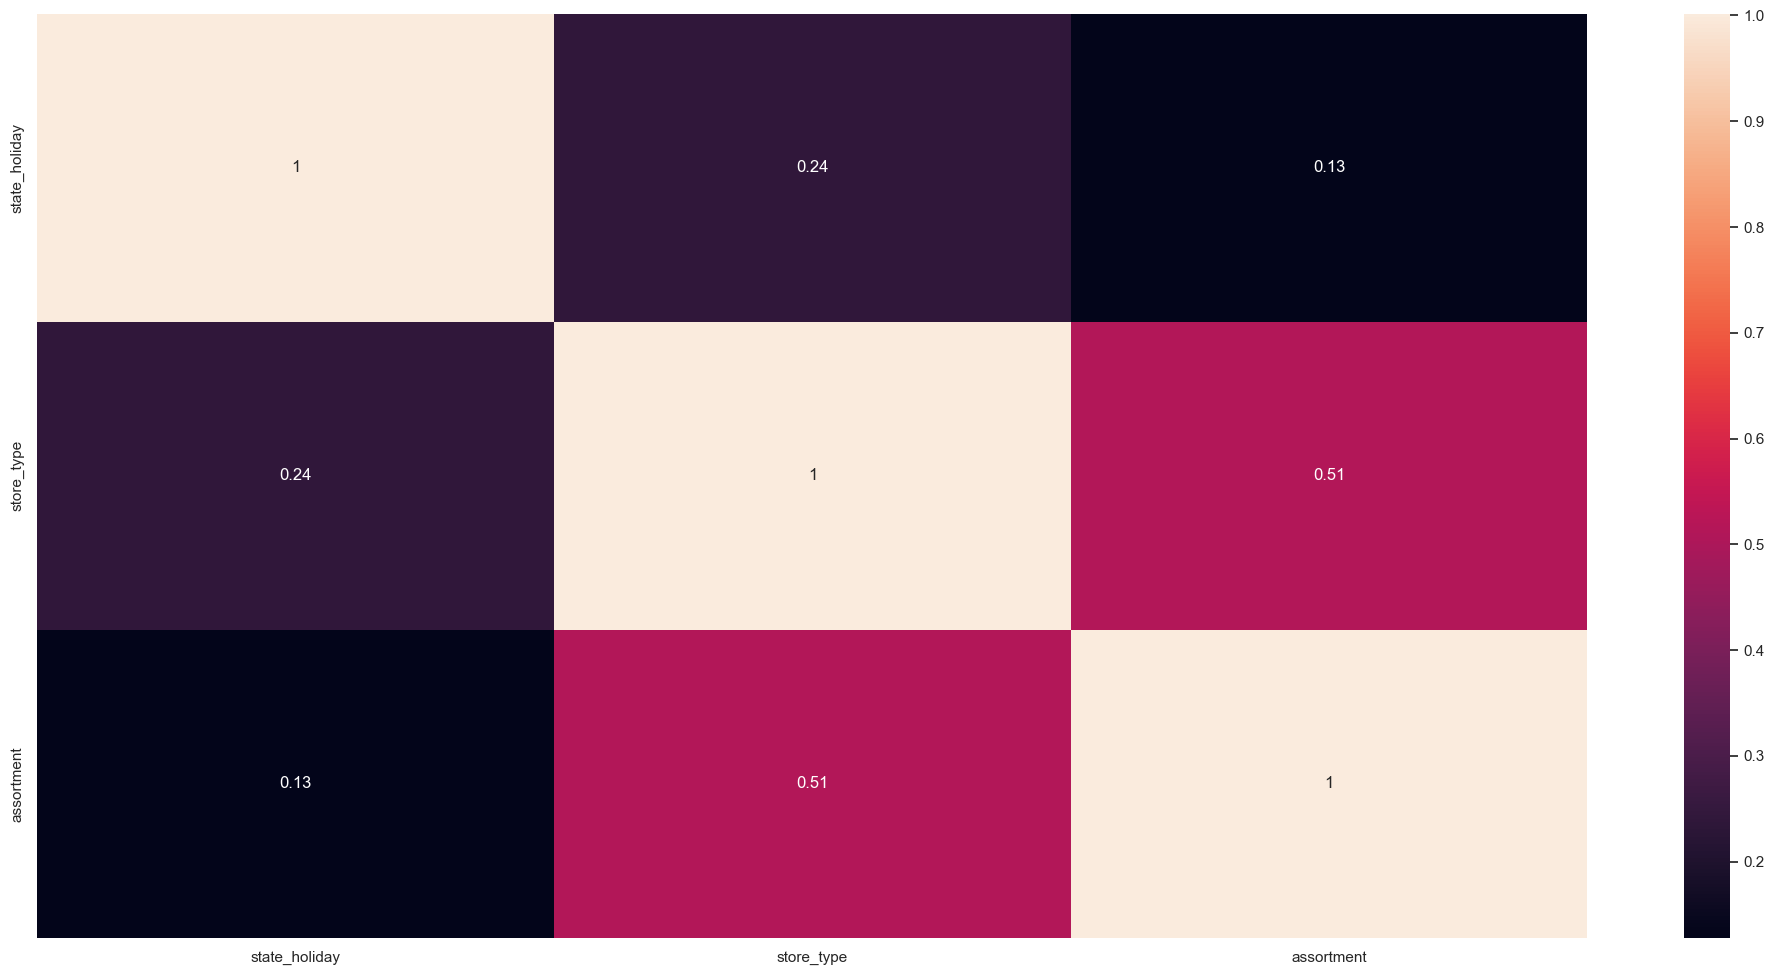

In [52]:
# Now check all the correlations among the Categorical Variables

# Calculate Cramer V

a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Creating the Matrix

d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9]} )
d = d.set_index( d.columns )

sns.heatmap( d, annot=True );


# Data Preparation (Fifth Step)

In [53]:
df5 = df4.copy()

## Standarlization

 We checked in (5.1.2  Numerical Variable) if we had already any normalized variable, Normal variable is when we have a variable without outliers 

## Rescaling

In [54]:
# Using methods from sklearn to rescale the variables, bringing them next to a common range

# Robustsacler is used when we have too many outliers 

rs = RobustScaler()

# MinMaxScaler is used when the variable has a pattern, with a little outliers

mms = MinMaxScaler()

# competition distance

df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# This part is going to be used in the exploitation part as API
#pickle.dump( rs, open('C:\\Users\\gabre\\DS IN PROGRESS\\DS_2023\\Ciclo_de_Preparacao\\Data_Science_em_Producao\\parameter\\competition_distance_scaler.pkl', 'wb') )

# competition time month

df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# This part is going to be used in the exploitation part as API
#pickle.dump( rs, open('C:\\Users\\gabre\\DS IN PROGRESS\\DS_2023\\Ciclo_de_Preparacao\\Data_Science_em_Producao\\parameter\\competition_time_month_scaler.pkl', 'wb') )

# promo time week

df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# This part is going to be used in the exploitation part as API
#pickle.dump( rs, open('C:\\Users\\gabre\\DS IN PROGRESS\\DS_2023\\Ciclo_de_Preparacao\\Data_Science_em_Producao\\parameter\\promo_time_week_scaler.pkl', 'wb') )

# year

df5['year'] = mms.fit_transform( df5[['year']].values )

# This part is going to be used in the exploitation part as API
#|pickle.dump( mms, open('C:\\Users\\gabre\\DS IN PROGRESS\\DS_2023\\Ciclo_de_Preparacao\\Data_Science_em_Producao\\parameter\\year_scaler.pkl', 'wb') )



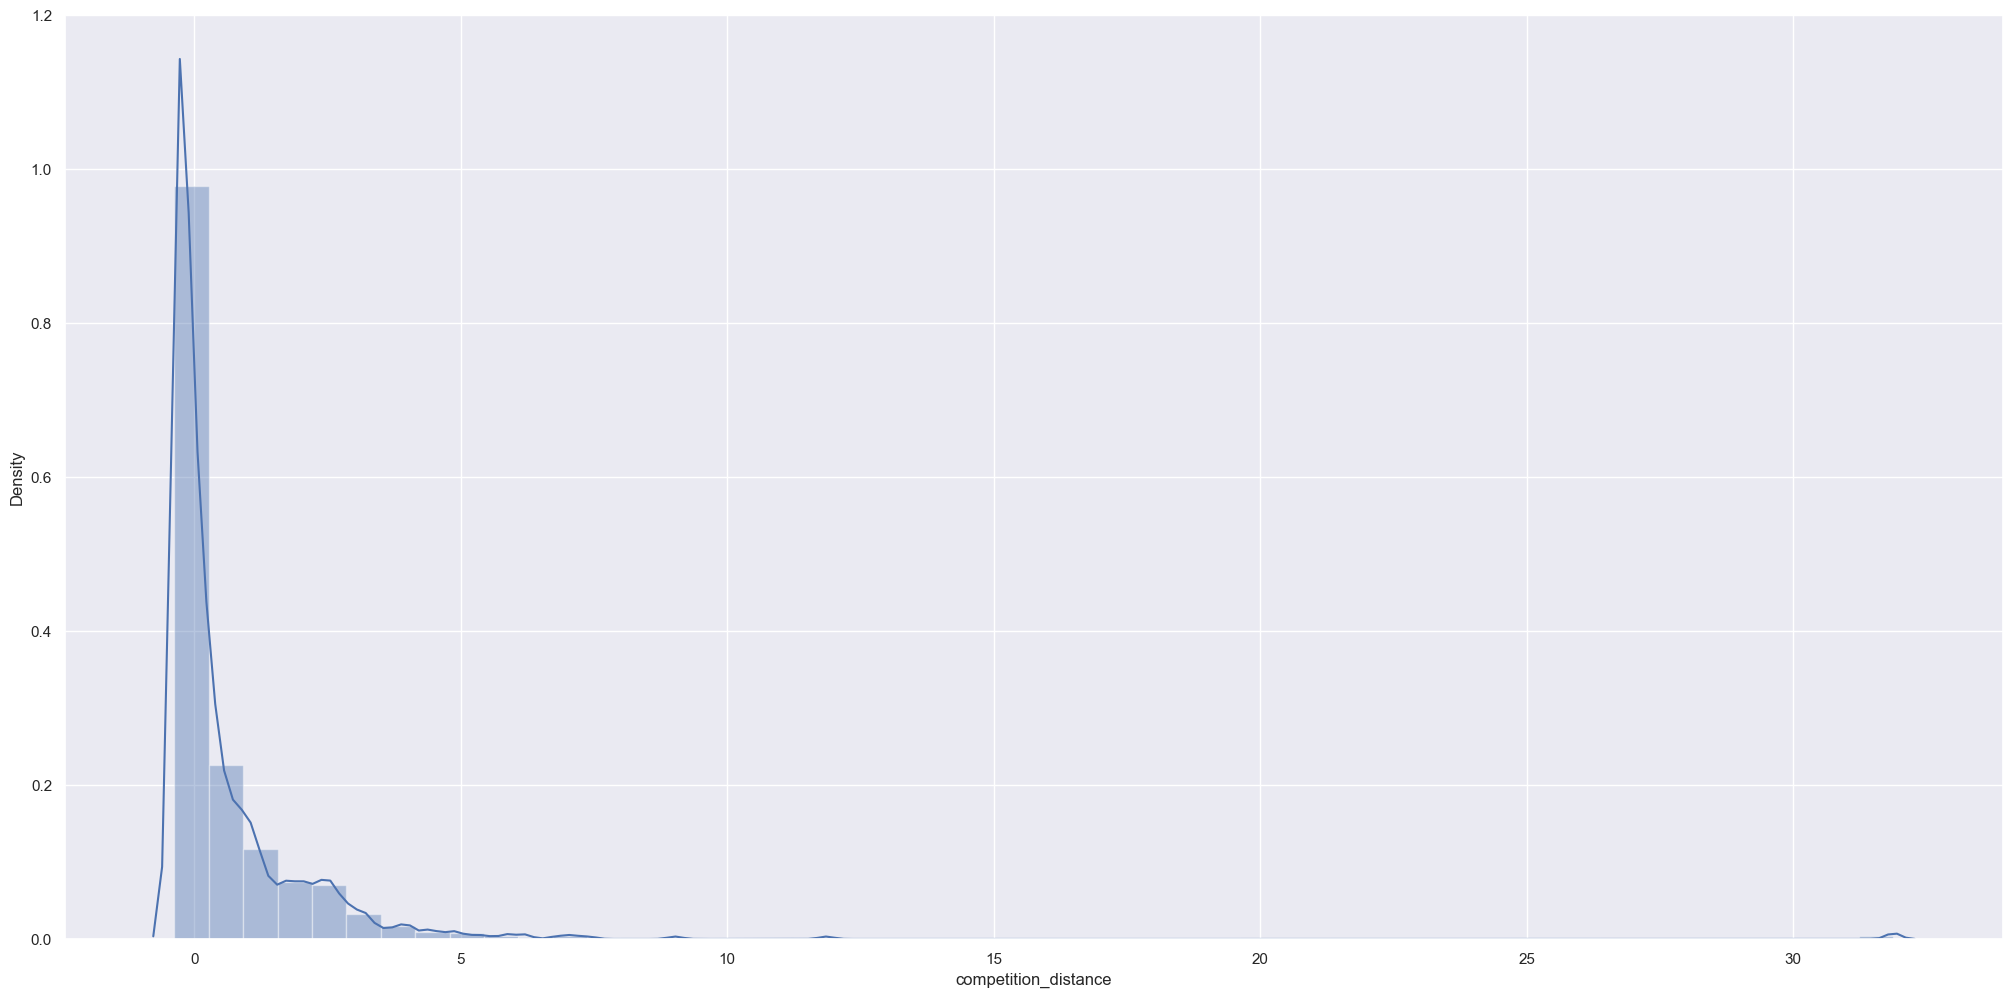

In [55]:
sns.distplot( df5['competition_distance'] );


In [56]:
df5.head()


,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


## Transformation

### Encoding

In [57]:
# State holiday - One Hot Encoding

df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# Store type - Label Encoding

le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# This code will be used in the exploitation step as API
#pickle.dump( le, open( 'C:\\Users\\gabre\\DS IN PROGRESS\\DS_2023\\Ciclo_de_Preparacao\\Data_Science_em_Producao\\parameter\\store_type_scaler.pkl', 'wb' ) )

assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )


In [58]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### Response Variable Transformation

In [59]:
df5['sales'] = np.log1p( df5['sales'] )

### Nature Transformation

In [60]:
# Day of Week

df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2 * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2 * np.pi/7 ) ) )

# Month

df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2 * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2 * np.pi/12 ) ) )

# Day

df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2 * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2 * np.pi/30 ) ) )

# Week of Year

df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2 * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2 * np.pi/52 ) ) )


In [61]:
df5.head()


,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# Feature Selection (Sixth Step)

In [62]:
df6 = df5.copy()

## Split the Dataframe into Training and Test

In [63]:
# Delete the columns that were used to create the new columns

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )


In [64]:
# Training dataset

X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Test dataset

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( f"Training Min Date { X_train['date'].min() }" )
print( f"Training Max Date { X_train['date'].max() }" )

print( f"\nTest Min date {X_test['date'].min()}" )
print( f"Test Max date {X_test['date'].max()}" )


Training Min Date 2013-01-01 00:00:00
Training Max Date 2015-06-18 00:00:00

Test Min date 2015-06-19 00:00:00
Test Max date 2015-07-31 00:00:00


## Boruta as Feature Selector

In [65]:
# training and test dataset for Boruta

#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor

#rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta

#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### Best Features Chosen by Boruta

In [66]:
#cols_selected = boruta.support_.tolist()

# best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## Manually Feature Adding

In [67]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# Machine Learning Modelling (Seventh Step)

In [68]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## Average Model

In [69]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# Prediction

aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# Performance

baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## Linear Regression

In [70]:
# Model

lr = LinearRegression().fit( x_train, y_train )

# Prediction

yhat_lr = lr.predict( x_test )

# Performance

lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### Linear Regression Model - Cross Validation

In [71]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## Linear Regression Regularized Model - Lasso

In [72]:
# Model

lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# Prediction

yhat_lrr = lrr.predict( x_test )

# Performance

lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### Lasso - Cross Validation

In [73]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## Random Forest Regressor

In [74]:
# Model

rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# Prediction

yhat_rf = rf.predict( x_test )

# Performance

rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### Random Forest - Cross Validation

In [75]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv



KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17


## XGBoost Regressor

In [76]:
# Model

model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9 ).fit( x_train, y_train )

# Prediction

yhat_xgb = model_xgb.predict( x_test )

# Performance

xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.544086,0.949457,7330.812159


### XGBoost - Cross Validation

In [77]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv



KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.17 +/- 588.63,0.95 +/- 0.0,7715.17 +/- 689.51


## Compare the Perfomance

### Single Performance

In [78]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.544086,0.949457,7330.812159


### Real Performance (Cross Validation)

In [79]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17
0,XGBoost Regressor,7049.17 +/- 588.63,0.95 +/- 0.0,7715.17 +/- 689.51


# Hyperparameter Fine Tuning (Eitghth Step)

## Random Search

In [80]:
'''param = {'n_estimators': [1000, 1500, 2000, 2500, 3000],
    'eta': [0.01, 0.03],
    'max_depth': [3, 6, 9],
    'subsample': [0.1, 0.4, 0.7],
    'colsample_bytree': [0.3, 0.6, 0.9],
    'min_child_weight': [3, 8, 12]}

MAX_EVAL = 10'''

"param = {'n_estimators': [1000, 1500, 2000, 2500, 3000],\n    'eta': [0.01, 0.03],\n    'max_depth': [3, 6, 9],\n    'subsample': [0.1, 0.4, 0.7],\n    'colsample_bytree': [0.3, 0.6, 0.9],\n    'min_child_weight': [3, 8, 12]}\n\nMAX_EVAL = 10"

In [81]:
'''final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # Choose the values for parameters randomly
    hp = { k: np.random.choice( v, 1 )[0] for k, v in param.items() }
    print( hp )
    
    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'], 
                                  eta=hp['eta'], 
                                  max_depth=hp['max_depth'], 
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'] )

    # performance
    result = cross_validation( x_training, 10, 'XGBoost Regressor', model_xgb, verbose=True )
    final_result = pd.concat( [final_result, result] )
        
final_result'''

"final_result = pd.DataFrame()\n\nfor i in range( MAX_EVAL ):\n    # Choose the values for parameters randomly\n    hp = { k: np.random.choice( v, 1 )[0] for k, v in param.items() }\n    print( hp )\n    \n    # model\n    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',\n                                  n_estimators=hp['n_estimators'], \n                                  eta=hp['eta'], \n                                  max_depth=hp['max_depth'], \n                                  subsample=hp['subsample'],\n                                  colsample_bytree=hp['colsample_bytree'],\n                                  min_child_weight=hp['min_child_weight'] )\n\n    # performance\n    result = cross_validation( x_training, 10, 'XGBoost Regressor', model_xgb, verbose=True )\n    final_result = pd.concat( [final_result, result] )\n        \nfinal_result"

In [82]:
# final_result.sort_values( 'RMSE CV', ascending=True )

NameError: name 'final_result' is not defined

## Final Model

In [83]:
# After testing the parameters, The most precise one was chosen below:

# {'n_estimators': 3000, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.6, 'min_child_weight': 12}

param_tuned = {
    'n_estimators': 3000, 
    'eta': 0.03, 
    'max_depth': 9, 
    'subsample': 0.1, 
    'colsample_bytree': 0.6, 
    'min_child_weight': 12
        }

In [84]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,640.526121,0.093286,934.833866


In [85]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

0.0015817572750591092

# Interpreting the Errors (Nineth Step)

MAE (Mean Absolute Error) - equal weight to all errors

MAPE (Mean Absolute Percentage Error) - shows how far the prediction is from the real value in percentage

RMSE (Root mean square Error) - Shows a more precisely  result than MAE

MPE ( Mean percentage Error) - Most used to increase the precise of the model, and idicates if the model is underestimating or superestimating


In [86]:
df7 = X_test[ cols_selected_boruta_full ]

# Rescale

df7['sales'] = np.expm1( df7['sales'] )
df7['predictions'] = np.expm1( yhat_xgb_tuned )


## Business Performance

In [87]:
# Sum predictions

df71 = df7[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE

df7_aux1 = df7[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df7_aux2 = df7[['store', 'sales', 'predictions']].groupby( 'store' ).apply(
    lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge

df7_aux3 = pd.merge( df7_aux1, df7_aux2, how='inner', on='store' )
df72 = pd.merge( df71, df7_aux3, how='inner', on='store' )

# Scenariosdf91

df72['worst_scenario'] = df72['predictions'] - df72['MAE']
df72['best_scenario'] = df72['predictions'] + df72['MAE']
7
# order columns

df72 = df72[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [88]:
df72.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104620.882812,101291.098479,107950.667146,3329.784334,0.553023
908,909,231406.000000,223667.388799,239144.611201,7738.611201,0.515073
875,876,197739.859375,193747.744894,201731.973856,3992.114481,0.306496
594,595,376960.625000,372845.696223,381075.553777,4114.928777,0.283111
721,722,350205.156250,348288.692185,352121.620315,1916.464065,0.254349


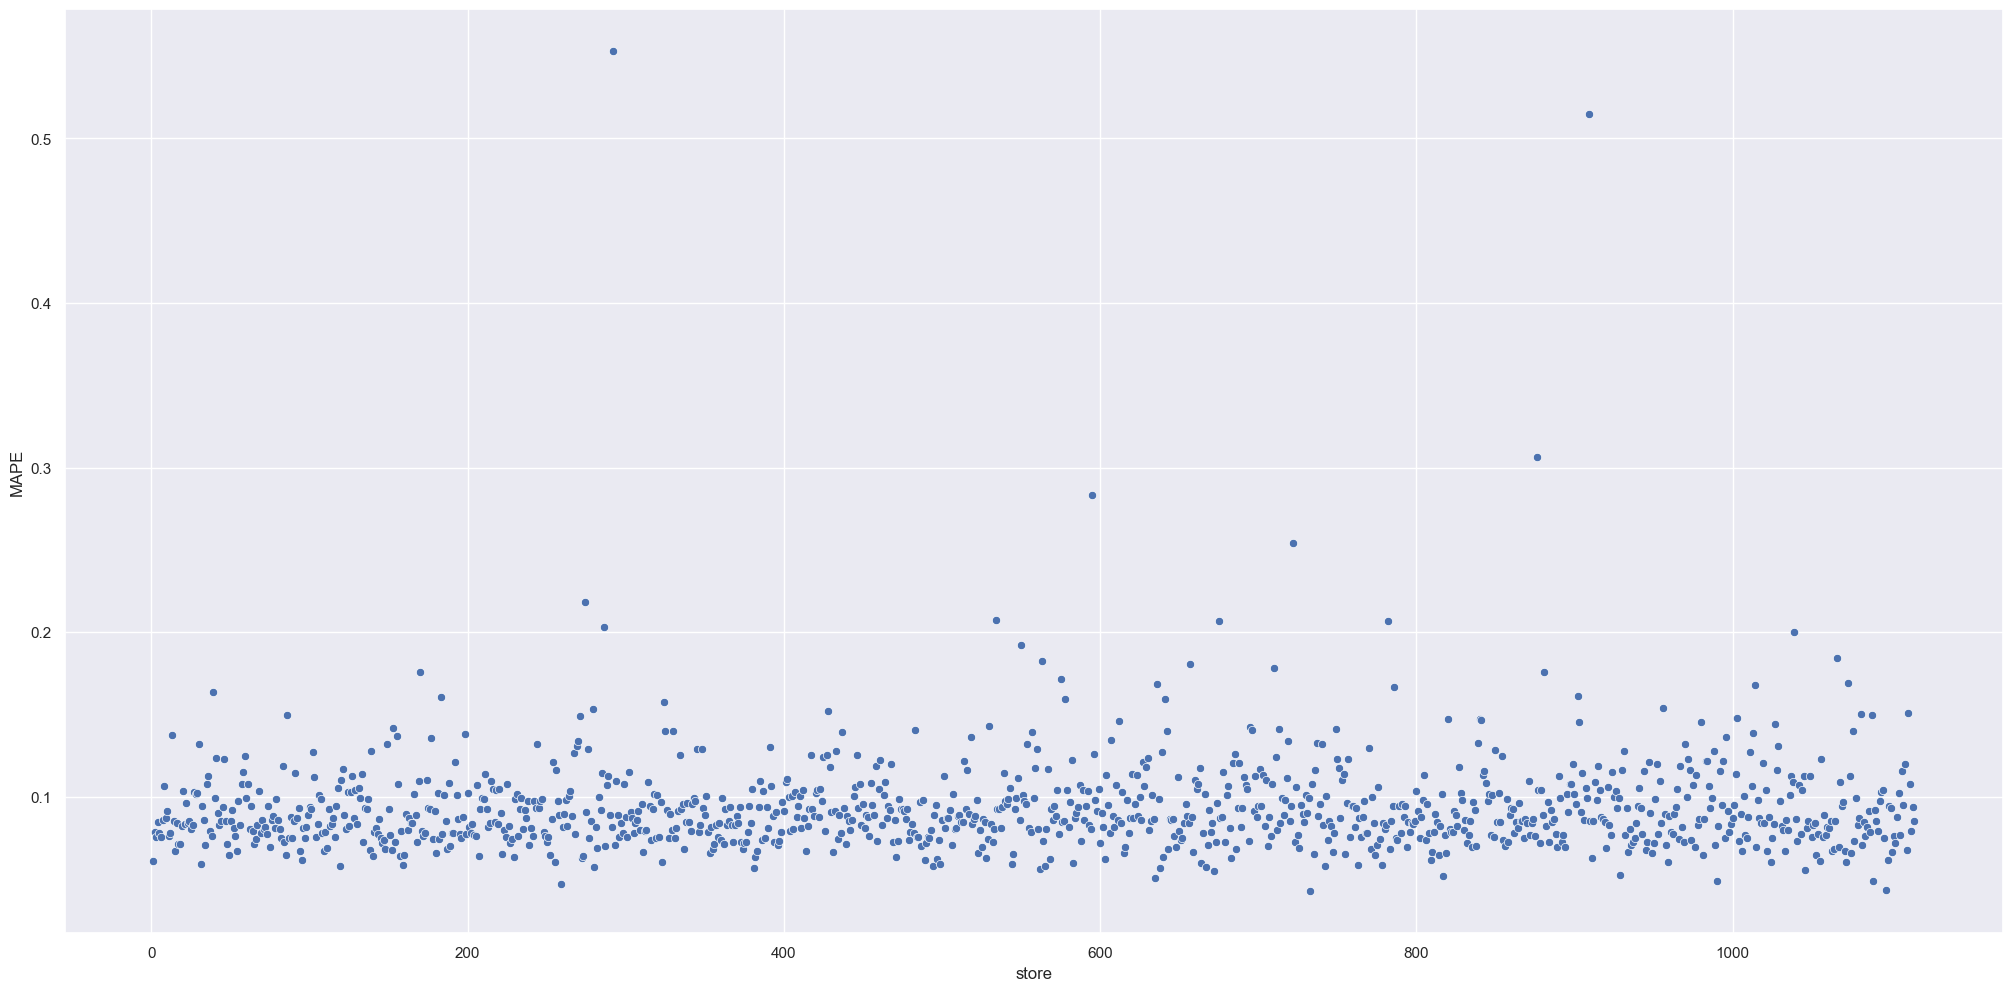

In [89]:
sns.scatterplot( x='store', y='MAPE', data=df72 );

## Total Performance

In [90]:
df73 = df72[['predictions', 'worst_scenario', 'best_scenario']].apply( 
    lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df73['Values'] = df73['Values'].map( 'R$ {:,.2f}'.format )
df73


,Scenario,Values
0,predictions,"R$ 284,342,400.00"
1,worst_scenario,"R$ 283,623,991.55"
2,best_scenario,"R$ 285,060,814.20"


## Machine Learning Performance

In [91]:
df7['error'] = df7['sales'] - df7['predictions']
df7['error_rate'] = df7['predictions'] / df7['sales']


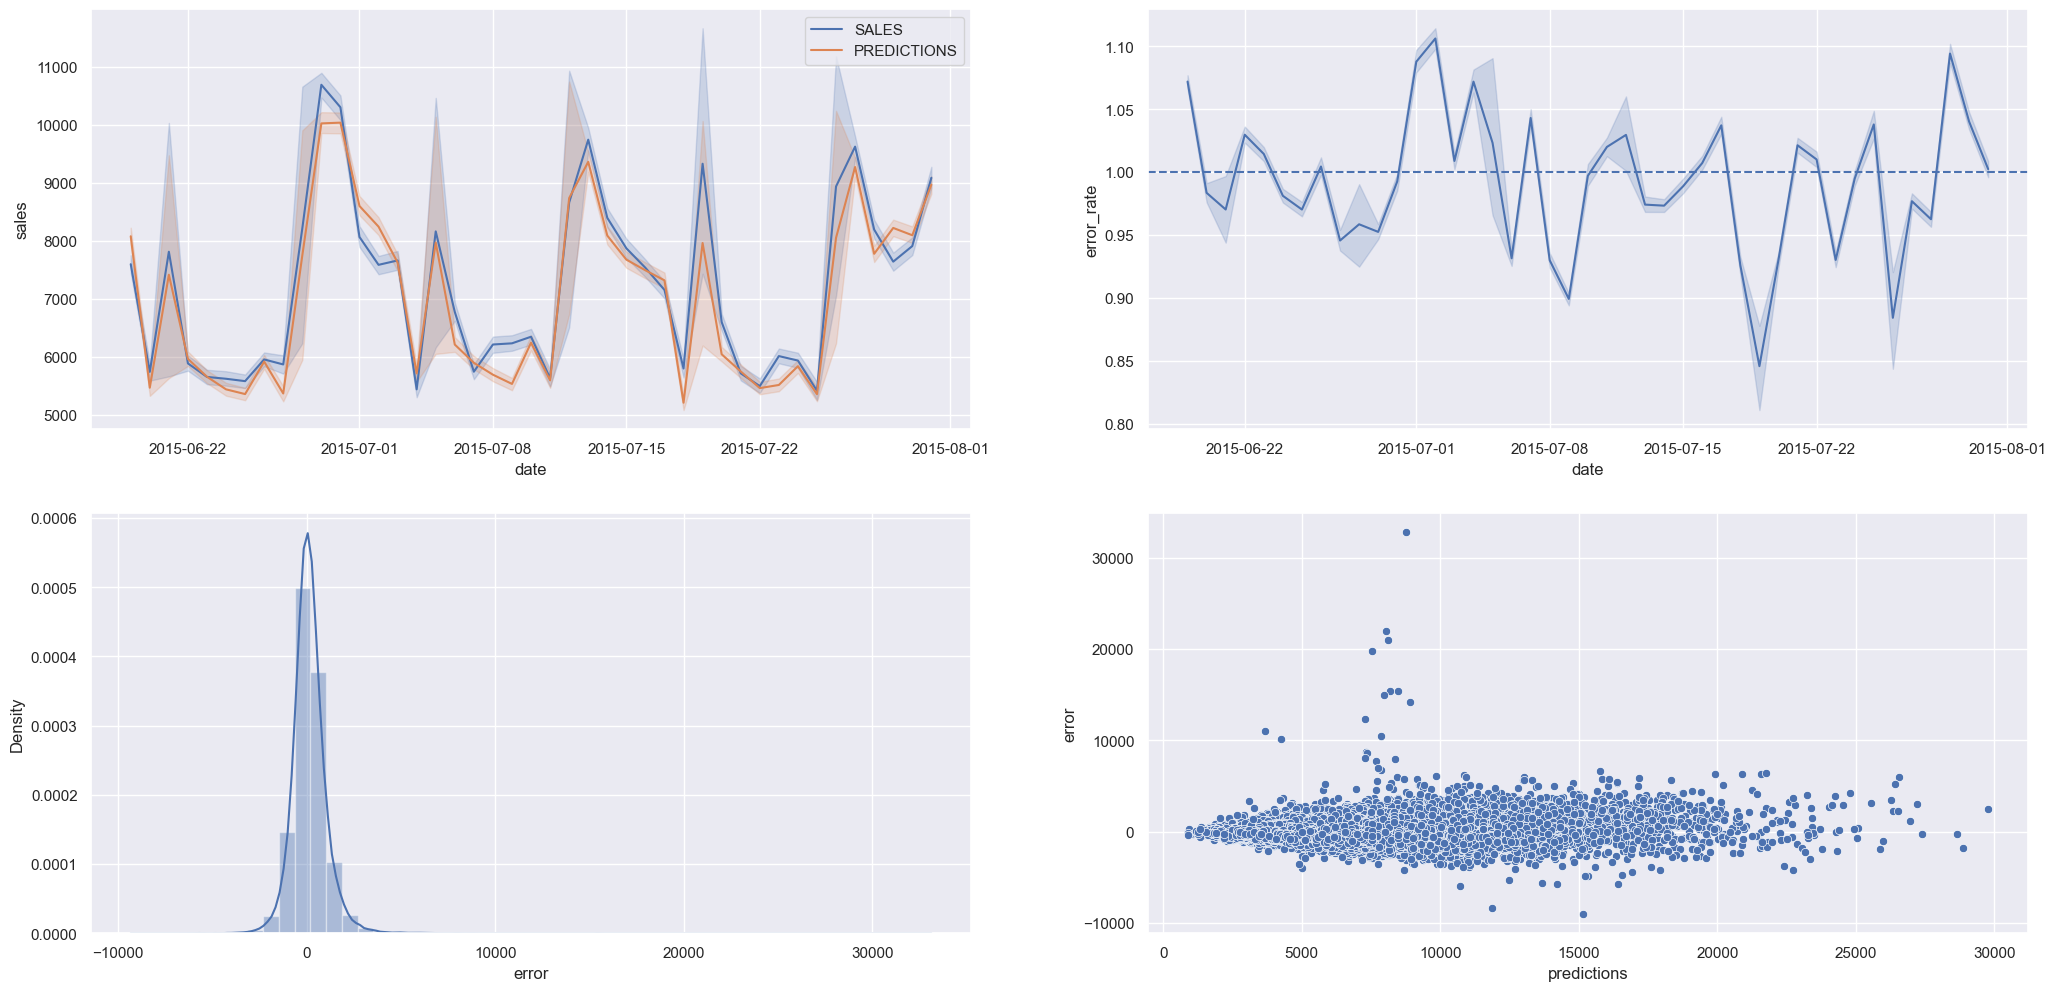

In [92]:
plt.subplot(2, 2, 1)
sns.lineplot( x='date', y='sales', data=df7, label='SALES' );
sns.lineplot( x='date', y='predictions', data=df7, label='PREDICTIONS' );

plt.subplot(2, 2, 2)
sns.lineplot( x='date', y='error_rate', data=df7 );
plt.axhline( 1, linestyle='--' )

plt.subplot(2, 2, 3)
sns.distplot( df7['error'] );

plt.subplot(2, 2, 4)
sns.scatterplot( x='predictions', y='error', data=df7 );


# Deploy Model to Production ( With Tester Local API ) (Tenth Step)

In [ ]:
# Save Trained Model

#pickle.dump( model_xgb_tuned, open( 'C:\\Users\\gabre\\DS IN PROGRESS\\DS_2023\\Ciclo_de_Preparacao\\Data_Science_em_Producao\\parameter\\model_rossmann.pkl', 'wb' ) )


## Rossmann Class

In [93]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime


class Rossmann(object):
    def __init__(self):
        self.home_path = 'C:\\Users\\gabre\\DS IN PROGRESS\\DS_2023\\Ciclo_de_Preparacao\\Data_Science_em_Producao\\'
        self.competition_distance_scaler = pickle.load( open( self.home_path + 'parameter\\competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter\\competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load( open( self.home_path + 'parameter\\promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load( open( self.home_path + 'parameter\\year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load( open( self.home_path + 'parameter\\store_type_scaler.pkl', 'rb'))

    def data_cleaning(self, df1):
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5. Fillout NA
        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(
            lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x[
                'competition_open_since_month'], axis=1)

        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(
            lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x[
                'competition_open_since_year'], axis=1)

        # promo2_since_week
        df1['promo2_since_week'] = df1.apply(
            lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply(
            lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # promo_interval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep',
                     10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
            lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0,
            axis=1)

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

        return df1

    def feature_engineering(self, df2):
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(
            lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],
                                        day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(
            int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(
            lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(
            lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda
                                                              x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)

        return df2

    def data_preparation(self, df5):
        ## 5.2. Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(
            df5[['competition_distance']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(
            df5[['competition_time_month']].values)

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))

        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance',
                         'competition_open_since_month',
                         'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year',
                         'competition_time_month', 'promo_time_week',
                         'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
                         'week_of_year_sin', 'week_of_year_cos']

        return df5[cols_selected]

    def get_prediction(self, model, original_data, test_data):
        # prediction

        pred = model.predict(test_data)

        # join pred into the original data

        original_data['prediction'] = np.expm1(pred)

        return original_data.to_json(orient='records', date_format='iso')
    

## API Handler

In [ ]:
'''import os
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model local Test

model = pickle.load(open(
    'C:\\Users\\gabre\\DS IN PROGRESS\\DS_2023\\Ciclo_de_Preparacao\\Data_Science_em_Producao\\parameter\\model_rossmann.pkl',
    'rb'))

# initialize API
app = Flask(__name__)


@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()

    if test_json:  # there is data
        if isinstance(test_json, dict):  # unique example
            test_raw = pd.DataFrame(test_json, index=[0])

        else:  # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # Instantiate Rossmann class
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # feature engineering
        df2 = pipeline.feature_engineering(df1)

        # data preparation
        df3 = pipeline.data_preparation(df2)

        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response

    else:
        return Reponse('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run( '192.168.1.104' )'''
    

## API Tester

In [95]:
# loading test dataset

df10 = pd.read_csv( 'C:\\Users\\gabre\\DS IN PROGRESS\\DS_2023\\Ciclo_de_Preparacao\\rossmann_prediction\\test.csv' )


In [103]:
# merge test dataset + store

df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# Choosing randoly stores just to test

random_stores_test = []

for i in range(10):
    random_stores_test.append( random.randint( 1, 500 ) )

# choose store for prediction

df_test = df_test[df_test['Store'].isin( random_stores_test )]

# remove closed days

df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [104]:
# convert Dataframe to json

data = json.dumps( df_test.to_dict( orient='records' ) )


In [105]:
# API Call

#url = 'http://192.168.1.104:5000/rossmann/predict'
url = 'https://teste-rossmann-prediction-api.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )

print( 'Status Code {}'.format( r.status_code ) )


Status Code 200


In [107]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,127,4,2015-09-17T00:00:00.000,1.0,1,regular_day,0,d,basic,1350.0,12,2005,1,13,2010,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2005-12-01T00:00:00.000,119,2010-03-22T00:00:00.000,286,7037.778809
1,135,4,2015-09-17T00:00:00.000,1.0,1,regular_day,0,d,basic,5190.0,9,2015,1,1,2013,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000,0,2012-12-31T00:00:00.000,141,4009.479736
2,189,4,2015-09-17T00:00:00.000,1.0,1,regular_day,0,d,basic,5760.0,7,2014,0,38,2015,0,Sep,0,2015,9,17,38,2015-37,2014-07-01T00:00:00.000,14,2015-09-14T00:00:00.000,0,6691.958008
3,197,4,2015-09-17T00:00:00.000,1.0,1,regular_day,0,c,basic,4210.0,3,2015,0,38,2015,0,Sep,0,2015,9,17,38,2015-37,2015-03-01T00:00:00.000,6,2015-09-14T00:00:00.000,0,5588.013672
4,305,4,2015-09-17T00:00:00.000,1.0,1,regular_day,0,c,extended,2470.0,2,2005,1,31,2013,"Mar,Jun,Sept,Dec",Sep,0,2015,9,17,38,2015-37,2005-02-01T00:00:00.000,129,2013-07-29T00:00:00.000,111,4788.517578


In [109]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

Store Number 127 will sell R$275,292.32 in the next 6 weeks
Store Number 135 will sell R$161,742.36 in the next 6 weeks
Store Number 189 will sell R$268,937.47 in the next 6 weeks
Store Number 197 will sell R$234,568.88 in the next 6 weeks
Store Number 305 will sell R$194,622.11 in the next 6 weeks
Store Number 330 will sell R$188,001.22 in the next 6 weeks
Store Number 399 will sell R$239,373.54 in the next 6 weeks
Store Number 405 will sell R$254,971.96 in the next 6 weeks


# Deploy Model to Production ( Online )

In [ ]:
# Save Trained Model

#pickle.dump( model_xgb_tuned, open( 'C:\\Users\\gabre\\DS IN PROGRESS\\DS_2023\\Ciclo_de_Preparacao\\Data_Science_em_Producao\\parameter\\model_rossmann.pkl', 'wb' ) )


## Rossmann Class

In [ ]:
'''import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime


class Rossmann(object):
    def __init__(self):
        self.home_path = ''
        self.competition_distance_scaler = pickle.load( open( self.home_path + 'parameter\\competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter\\competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load( open( self.home_path + 'parameter\\promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load( open( self.home_path + 'parameter\\year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load( open( self.home_path + 'parameter\\store_type_scaler.pkl', 'rb'))

    def data_cleaning(self, df1):
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5. Fillout NA
        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(
            lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x[
                'competition_open_since_month'], axis=1)

        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(
            lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x[
                'competition_open_since_year'], axis=1)

        # promo2_since_week
        df1['promo2_since_week'] = df1.apply(
            lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply(
            lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # promo_interval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep',
                     10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
            lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0,
            axis=1)

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

        return df1

    def feature_engineering(self, df2):
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(
            lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],
                                        day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(
            int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(
            lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(
            lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda
                                                              x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)

        return df2

    def data_preparation(self, df5):
        ## 5.2. Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(
            df5[['competition_distance']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(
            df5[['competition_time_month']].values)

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))

        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance',
                         'competition_open_since_month',
                         'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year',
                         'competition_time_month', 'promo_time_week',
                         'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
                         'week_of_year_sin', 'week_of_year_cos']

        return df5[cols_selected]

    def get_prediction(self, model, original_data, test_data):
        # prediction

        pred = model.predict(test_data)

        # join pred into the original data

        original_data['prediction'] = np.expm1(pred)

        return original_data.to_json(orient='records', date_format='iso')'''
    

## API Handler

'''import os
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# Loading in web

model = pickle.load(open( 'model\\model_rossmann.pkl', 'rb'))

# initialize API
app = Flask(__name__)


@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()

    if test_json:  # there is data
        if isinstance(test_json, dict):  # unique example
            test_raw = pd.DataFrame(test_json, index=[0])

        else:  # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # Instantiate Rossmann class
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # feature engineering
        df2 = pipeline.feature_engineering(df1)

        # data preparation
        df3 = pipeline.data_preparation(df2)

        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response

    else:
        return Reponse('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    port = os.environ.get( 'PORT', 5000 )
    app.run( host='192.168.1.104', port = port)'''
    

In [ ]:
#pip freeze

In [ ]:
#pip list --format=freeze > requirements.txt

In [ ]:
#import sys
#print(sys.version)

In [ ]:
data

In [110]:
ssh -R 80:localhost:5000 localhost.run

SyntaxError: invalid syntax (73459655.py, line 1)